# Brief

In this notebook, we conduct a detailed analysis combining sentiment analysis using BERT without fine-tuning from RTRS audit reports with PCA. To further understand the complex relationships between these two analyses, we explore several advanced dimensionality reduction methods. 

## Import Data

In [1]:
import re
import torch
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from collections import Counter
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from nltk import ngrams
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
rtrs_df = pd.read_csv('/kaggle/input/rtrs-brazil-public-audit-reports-2023/brazil_rtrs.csv', encoding = 'iso-8859-14', decimal = ',')

In [3]:
rtrs_df.iloc[:, 12:].head(5)

1_1_criteria  \
0  The producer demonstrates knowledge of applica...   
1  Producers demonstrated knowledge of applicable...   
2  Evidenced through documentary evaluation and i...   
3  The farm remains up to date with applicable la...   
4  Producers demonstrate knowledge of applicable ...   

                                        1_2_criteria  \
0  The right to use the land was evidenced throug...   
1  The right to use the land was evidenced throug...   
2  Evidenced through documentary evaluation of CA...   
3  The property only has its own areas with regis...   
4  The right to use the land was evidenced throug...   

                                        1_3_criteria  \
0  The manager carried out a social, environmenta...   
1  The group manager carried out a socio-environm...   
2  Evidenced through documentary evaluation, the ...   
3  First year of certification, progress will be ...   
4  The manager carried out a social, environmenta...   

                                        2_1_criteria  \
0  In none of the audited farms was there evidenc...   
1  Through interviews with permanent and temporar...   
2  According to visual assessment of signs fixed ...   
3  Employees are free to leave the farm and have ...   
4  In none of the audited farms was there evidenc...   

                                        2_2_criteria  \
0  All employees on the audited farms are registe...   
1  All workers have employment contracts signed w...   
2  According to documentary evaluation, it was ve...   
3  Employees have signed employment contracts att...   
4  All employees on the audited farms are registe...   

                                        2_3_criteria  \
0  The audited farm has a PGR, where health and s...   
1  The workers demonstrated in interviews their k...   
2  By demonstrating the delivery of PPE and healt...   
3  Those responsible for the farm demonstrated kn...   
4  All audited farms have a PGR, where health and...   

                                        2_4_criteria  \
0  According to reports obtained through intervie...   
1  Through interviews with permanent and temporar...   
2  According to interviews with managers and empl...   
3  No local union maintains contact with the empl...   
4  According to reports obtained through intervie...   

                                        2_5_criteria  \
0  Verified from interviews, information collecte...   
1  Salaries are paid monthly, according to report...   
2  According to the documentary evaluation of the...   
3  Although there is no collective agreement or c...   
4  Verified from interviews, information collecte...   

                                        3_1_criteria  \
0  The farms have e-mail and telephone numbers an...   
1  Sign verified on the propertys entrance road c...   
2  According to visual assessment, it was evident...   
3  The local community can contact the farm via t...   
4  The farms have e-mail and telephone numbers an...   

                                        3_2_criteria  ...  \
0  Verified that there are no cases of disputes r...  ...   
1  The audited properties CondomÃ­nio Milla and B...  ...   
2  Not applicable, as there are no indigenous com...  ...   
3   The farm manager/group manager has maps ident...  ...   
4  Verified that there are no cases of disputes r...  ...   

                                        5_2_criteria  \
0  The farms have complete maps with the location...   
1  As demonstrated through contracts, the CondomÃ...   
2  At Fazenda Santa Cruz, there is no use of irri...   
3  Verified during visits and on maps that forest...   
4  The farms have complete maps with the location...   

                                        5_3_criteria  \
0  Soil quality is preserved on all audited farms...   
1  Soil analyzes are carried out to monitor organ...   
2  Solid analysis carried out in 2021, issued by ...   
3  Soil analyzes are carried out with precision a...   
4  Soil quality is pres

# Clean and EDA

In [4]:
def clean_string(input_string):
    cleaned_string = unidecode.unidecode(input_string.lower())
    return re.sub(r'[^a-z0-9\s]', ' ', re.sub(r'\s+', ' ', cleaned_string))

In [5]:
rtrs_df.iloc[:, 13:].columns

Index(['1_2_criteria', '1_3_criteria', '2_1_criteria', '2_2_criteria',
       '2_3_criteria', '2_4_criteria', '2_5_criteria', '3_1_criteria',
       '3_2_criteria', '3_3_criteria', '3_4_criteria', '4_1_criteria',
       '4_2_criteria', '4_3_criteria', '4_4_criteria', '4_5_criteria',
       '5_1_criteria', '5_2_criteria', '5_3_criteria', '5_4_criteria',
       '5_5_criteria', '5_6_criteria', '5_7_criteria', '5_8_criteria',
       '5_9_criteria', '5_10_criteria', '5_11_criteria'],
      dtype='object')

In [6]:
cols_nan = rtrs_df.columns[rtrs_df.isnull().any()]

if cols_nan.empty:
    print("No MV.")
else:
    print("Cols w/ Missing Values:")
    for col in cols_nan:
        print(col)

No MV.


In [7]:
text_columns = rtrs_df.iloc[:, 12:]

In [8]:
for i in text_columns:
    text_columns[i] = text_columns[i].map(lambda x: clean_string(x))

In [9]:
def create_corpus(df, text_column='text'):
    stop = set(stopwords.words('english'))
    corpus = []
    
    for tweet in tqdm(df[text_column]):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) and (word not in stop))]
        sentence = ' '.join(words)
        corpus.append(sentence)
    
    return corpus

In [10]:
for i in text_columns:
    text_columns[i] = create_corpus(text_columns, text_column=i)

100%|██████████| 128/128 [00:00<00:00, 3030.94it/s]


In [11]:
def analyze_text_lengths(df):
    analysis_results = []

    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)))
        sentences = sent_tokenize(' '.join(df[column].dropna().astype(str)))
        
        avg_word_length = np.mean([len(word) for word in words])
        avg_sentence_length = np.mean([len(sentence.split()) for sentence in sentences])
        
        analysis_results.append([column, avg_word_length, avg_sentence_length])
    
    return pd.DataFrame(analysis_results, columns=["Column", "Avg Word Length", "Avg Sentence Length"])

In [12]:
text_analysis_df = analyze_text_lengths(text_columns)

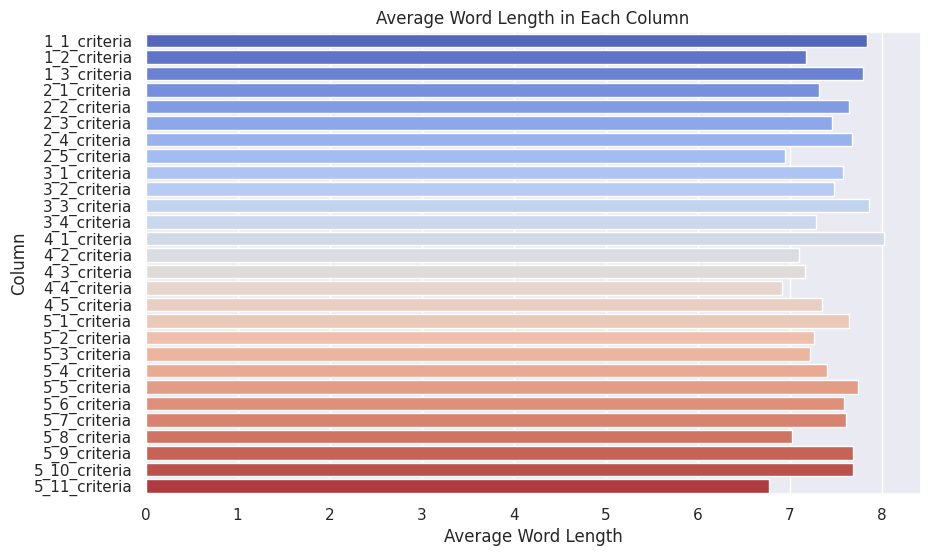

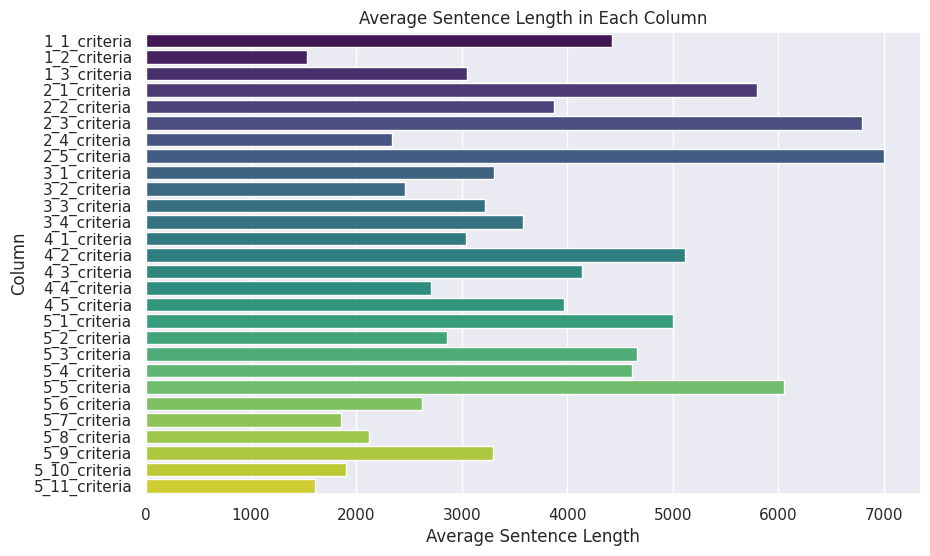

In [13]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="Avg Word Length", y="Column", data=text_analysis_df, palette="coolwarm")
plt.title("Average Word Length in Each Column")
plt.xlabel("Average Word Length")
plt.ylabel("Column")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Avg Sentence Length", y="Column", data=text_analysis_df, palette="viridis")
plt.title("Average Sentence Length in Each Column")
plt.xlabel("Average Sentence Length")
plt.ylabel("Column")
plt.show()

In [14]:
def word_frequency_analysis(df):
    freq_dict = {}
    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)).lower())
        word_freq = Counter(words)
        freq_dict[column] = word_freq
    return freq_dict

In [15]:
word_freqs = word_frequency_analysis(text_columns)

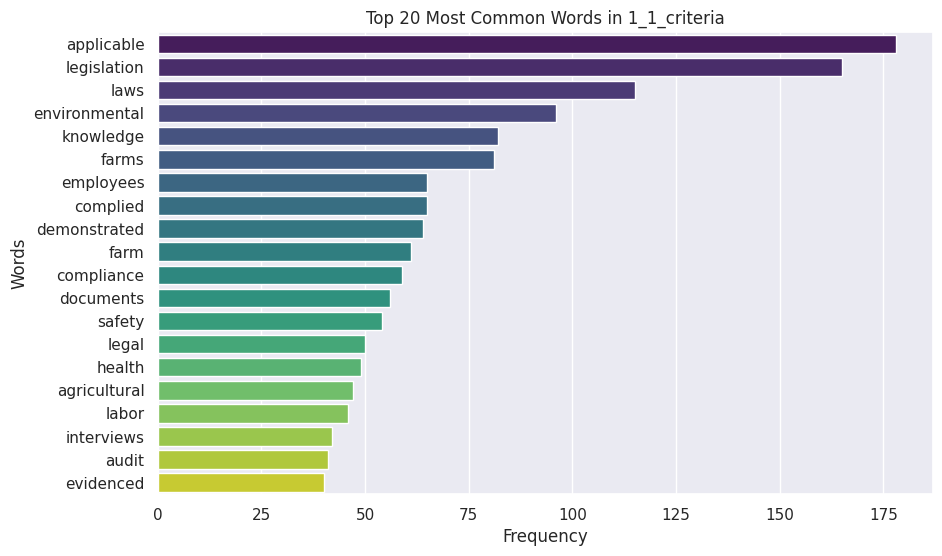

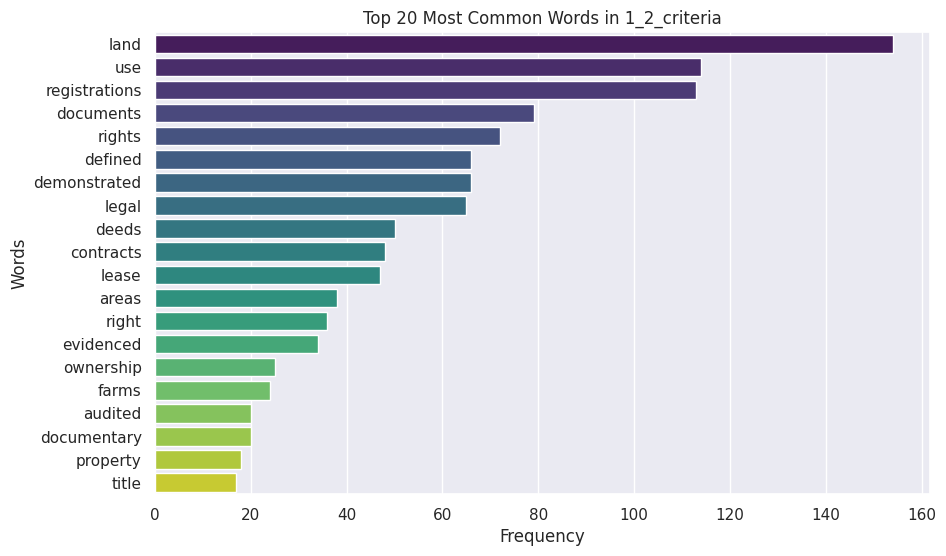

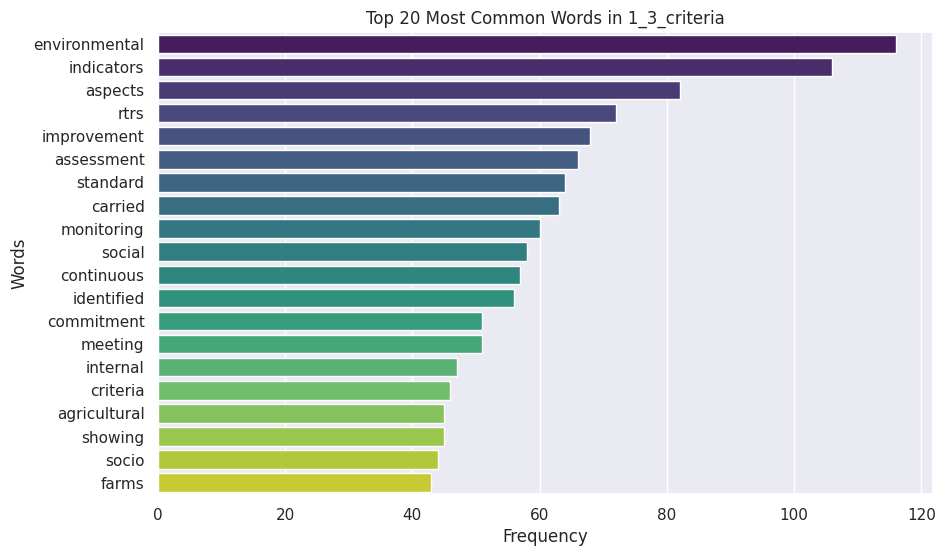

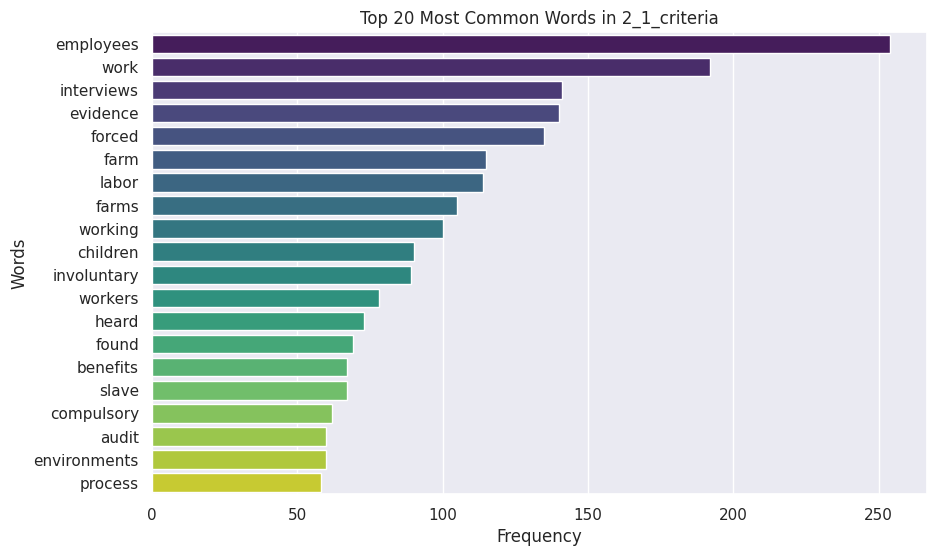

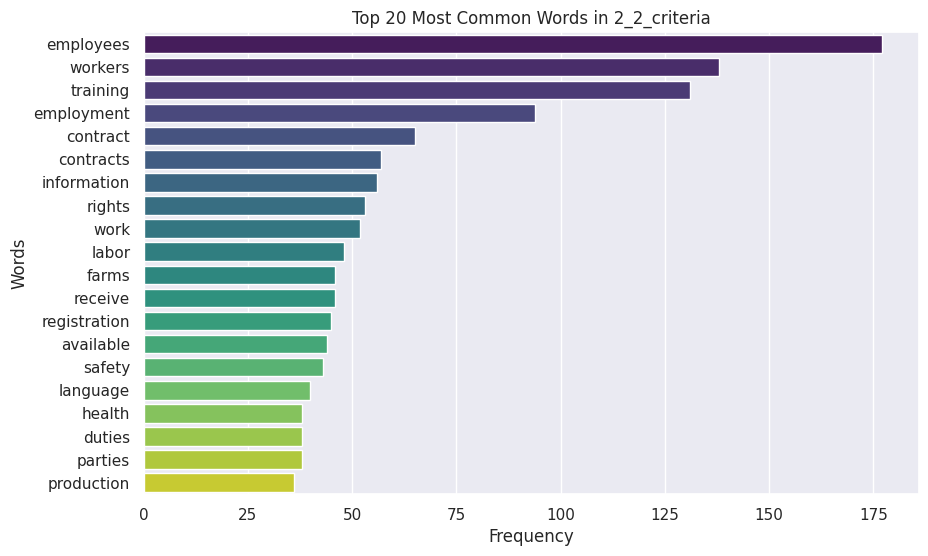

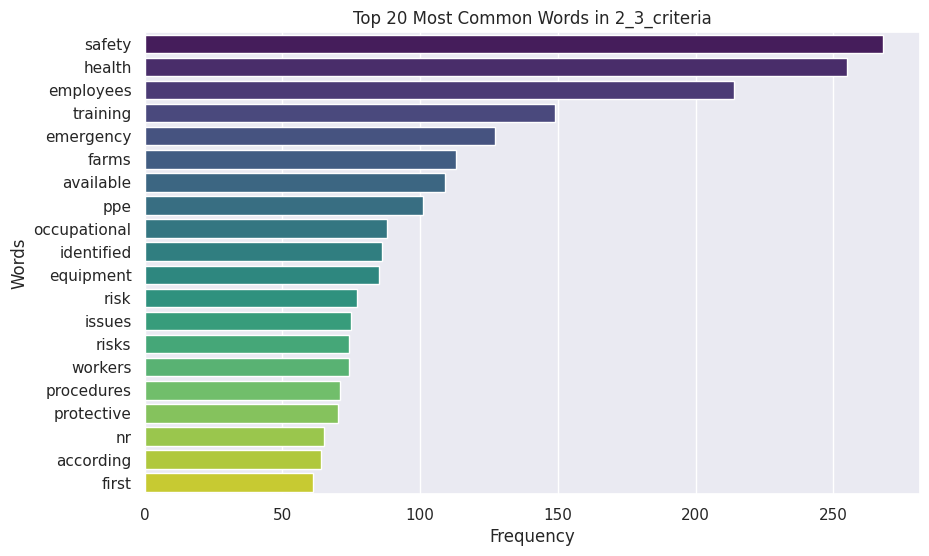

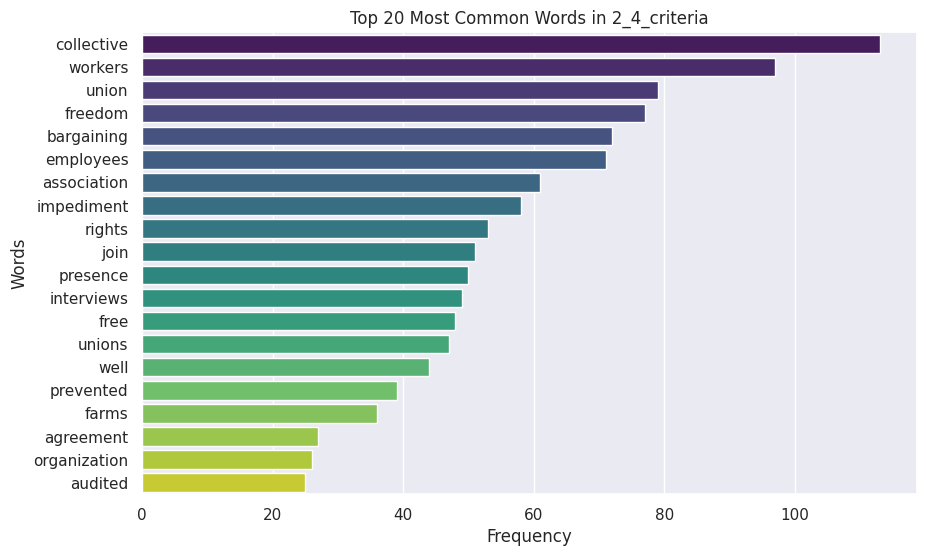

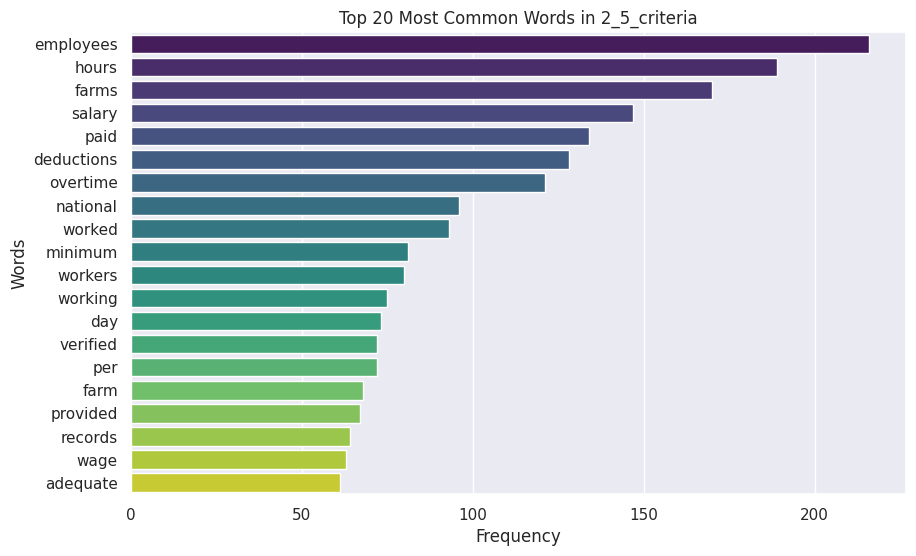

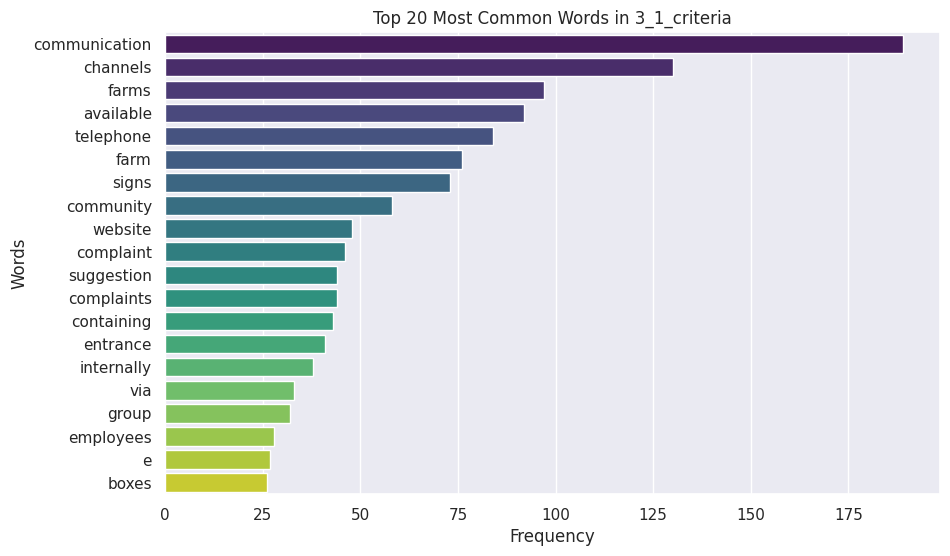

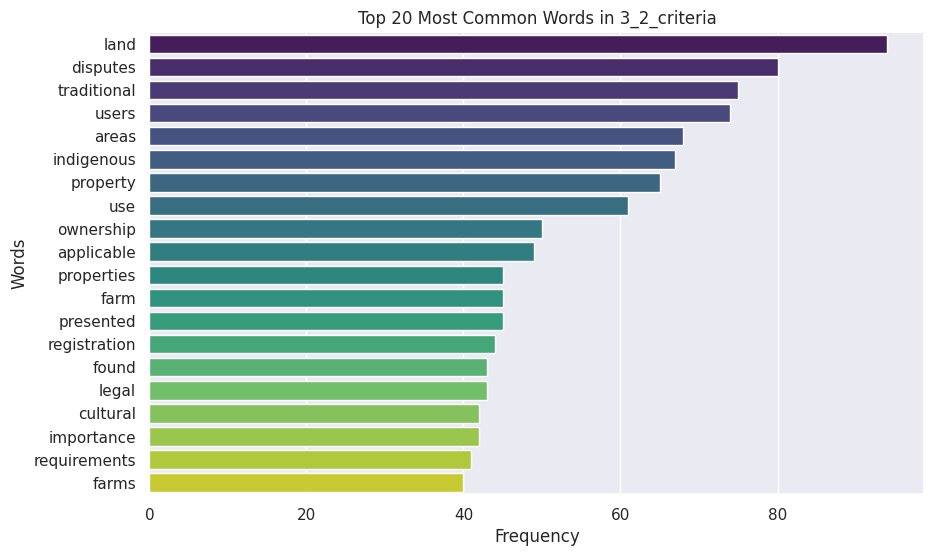

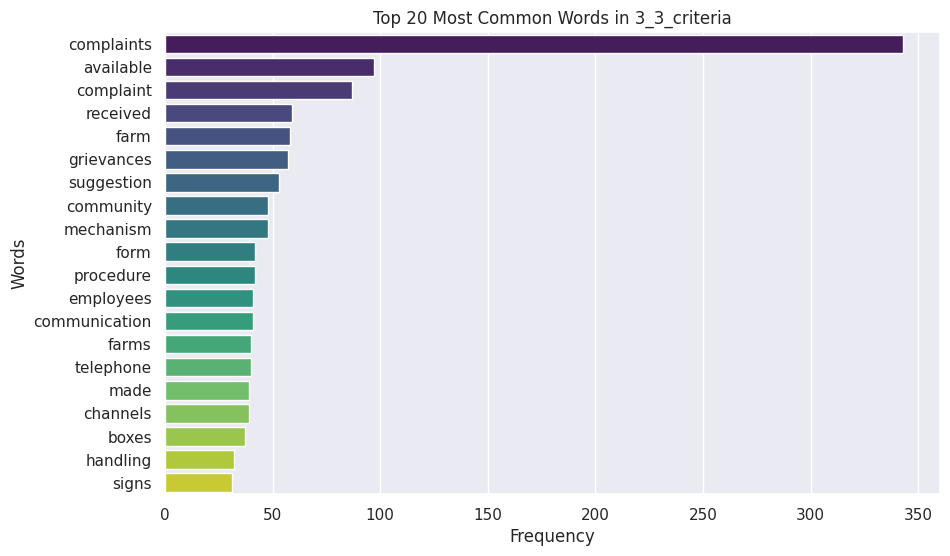

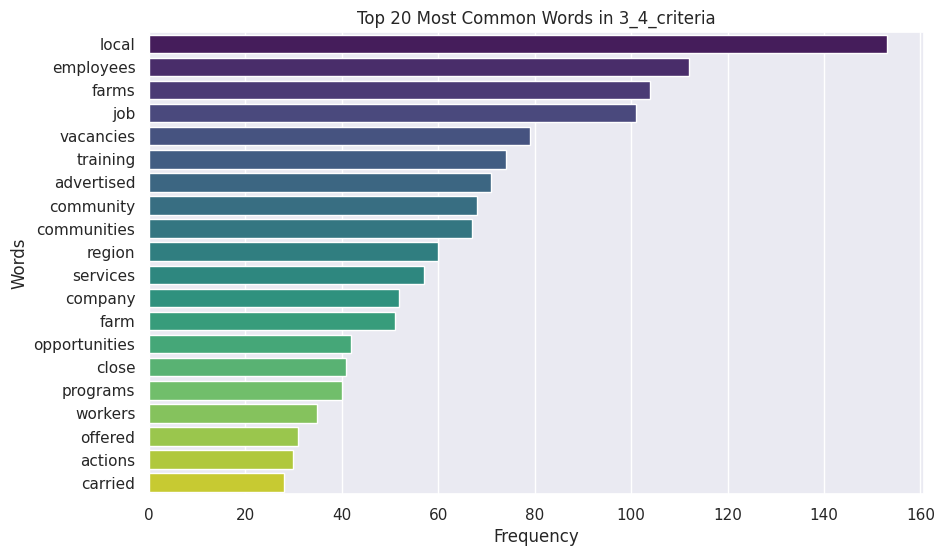

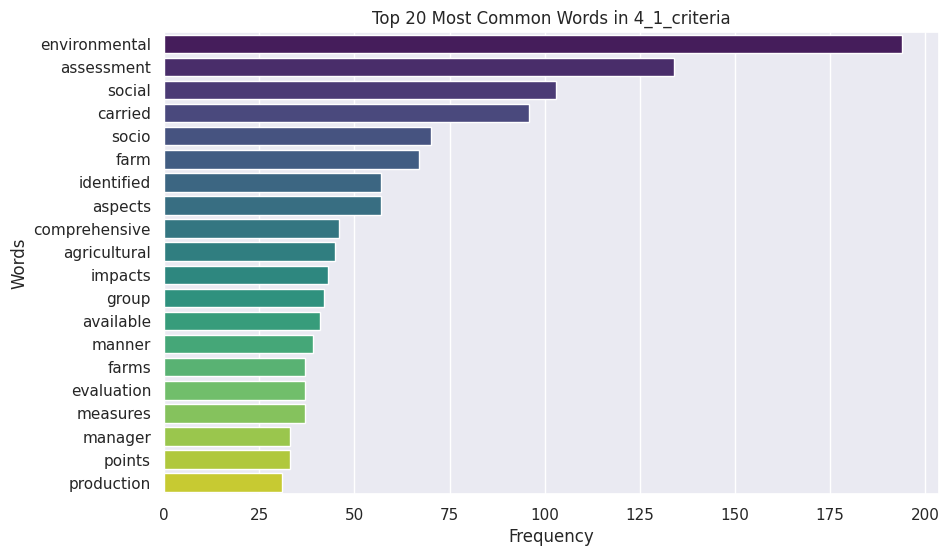

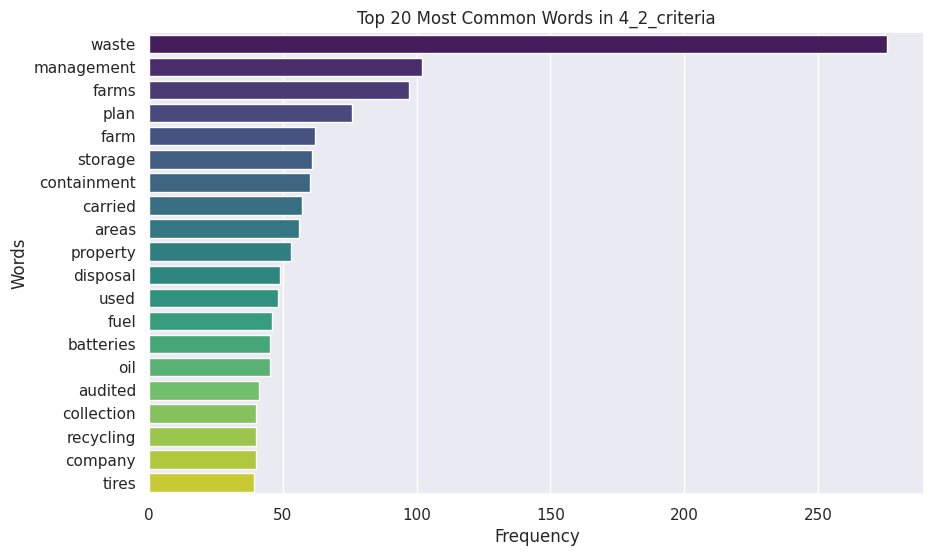

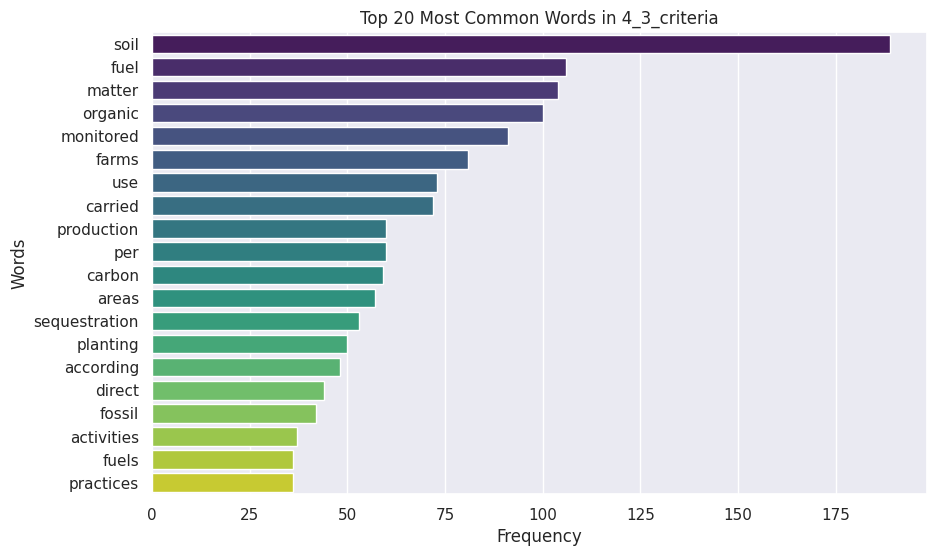

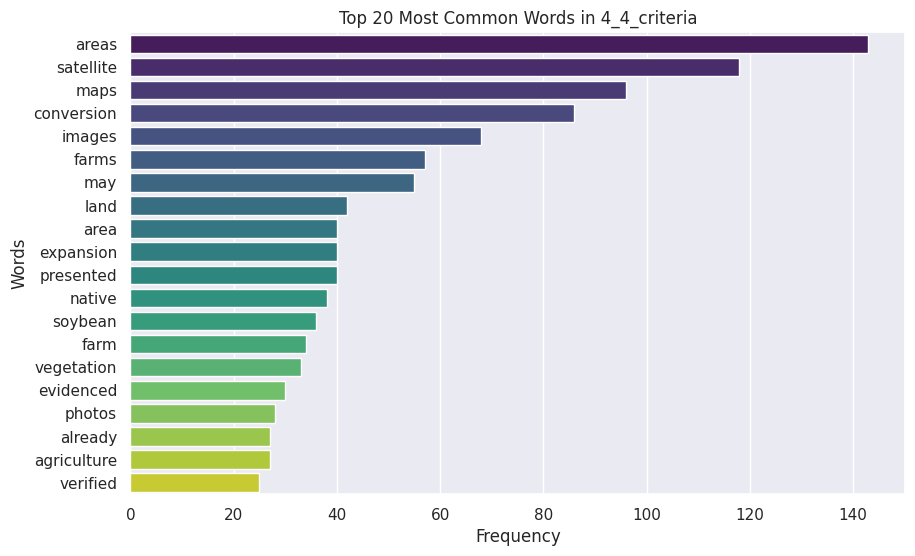

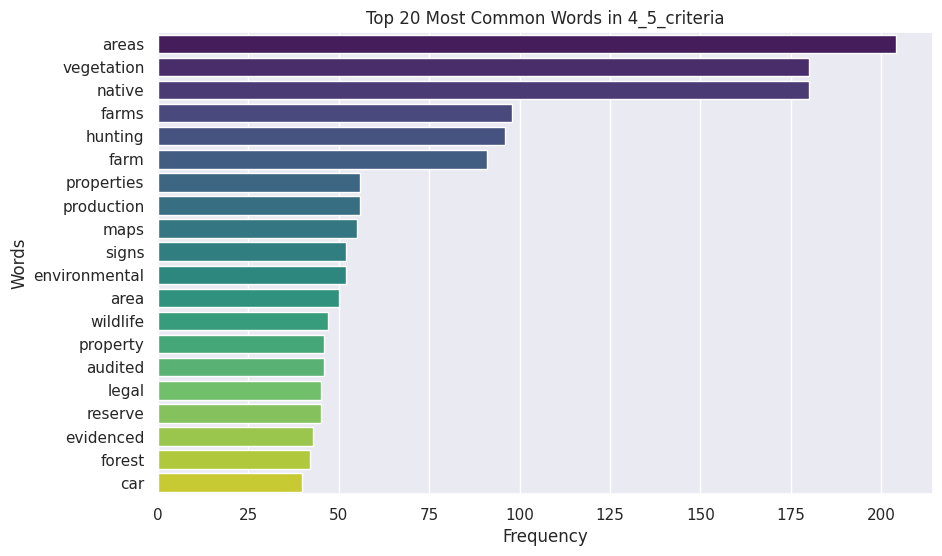

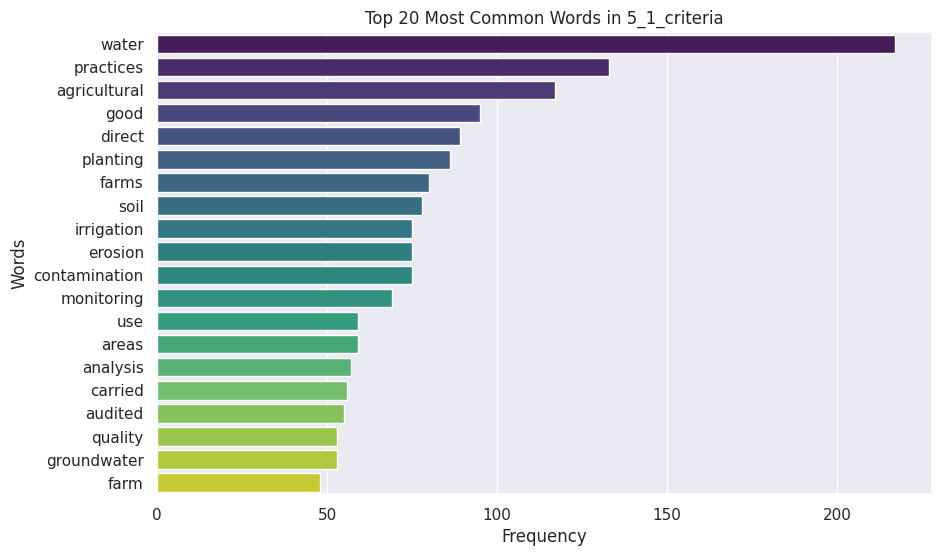

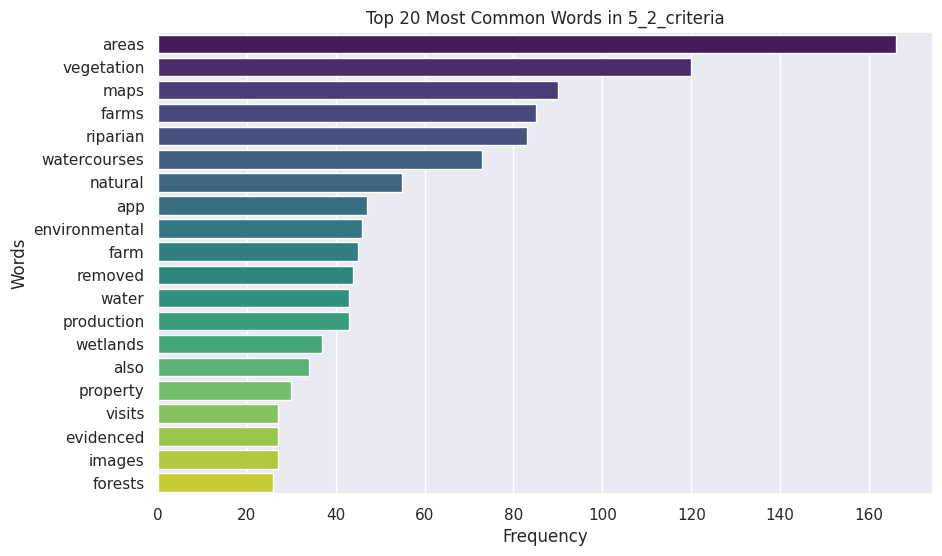

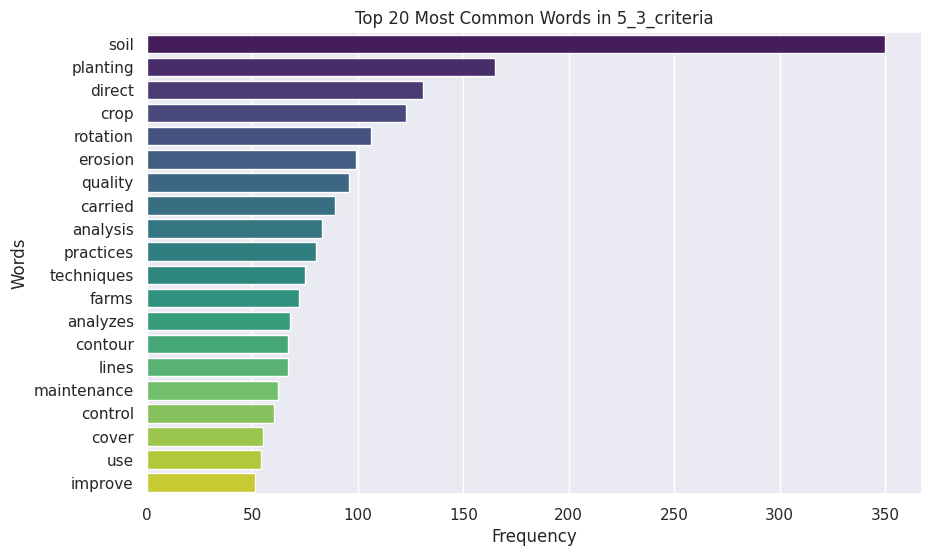

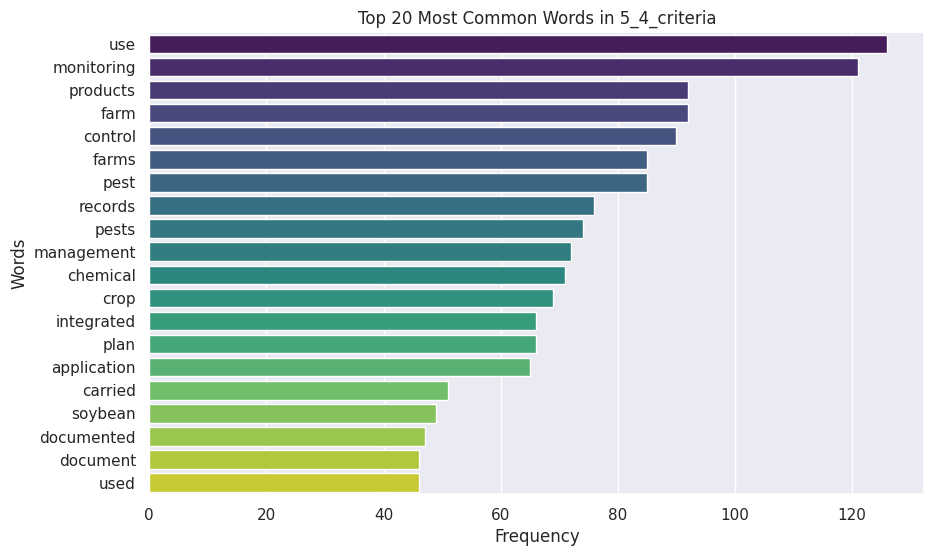

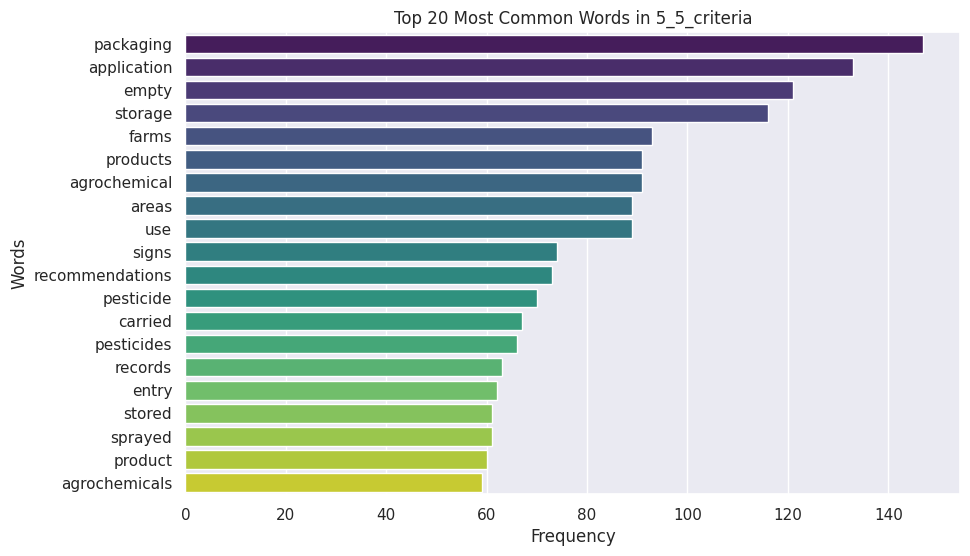

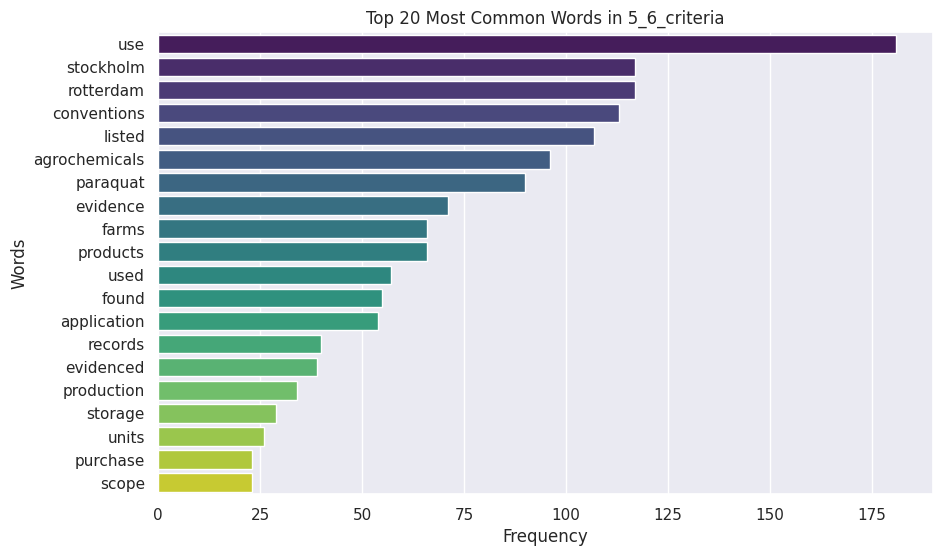

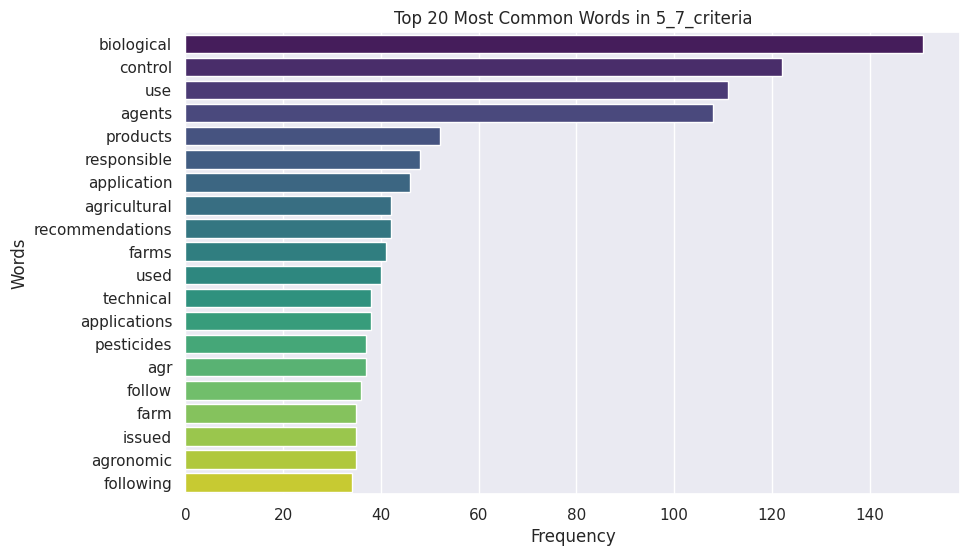

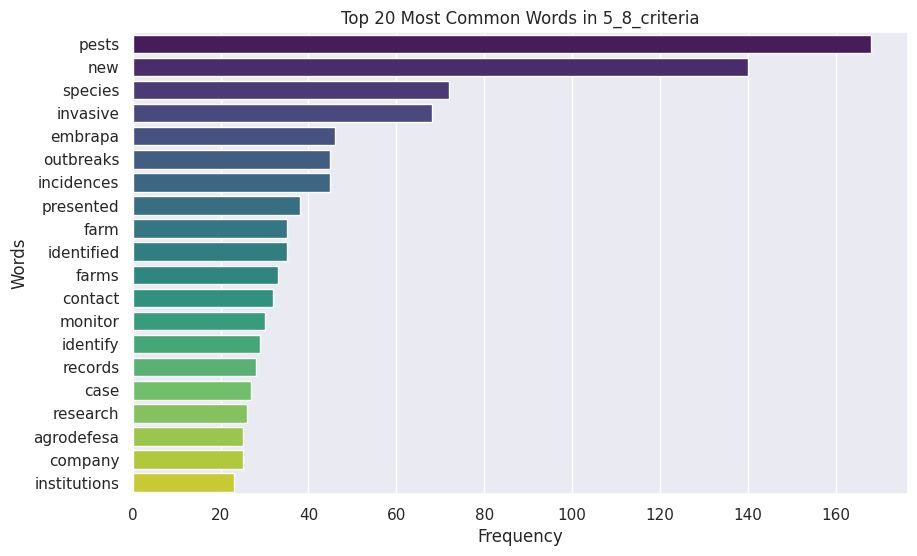

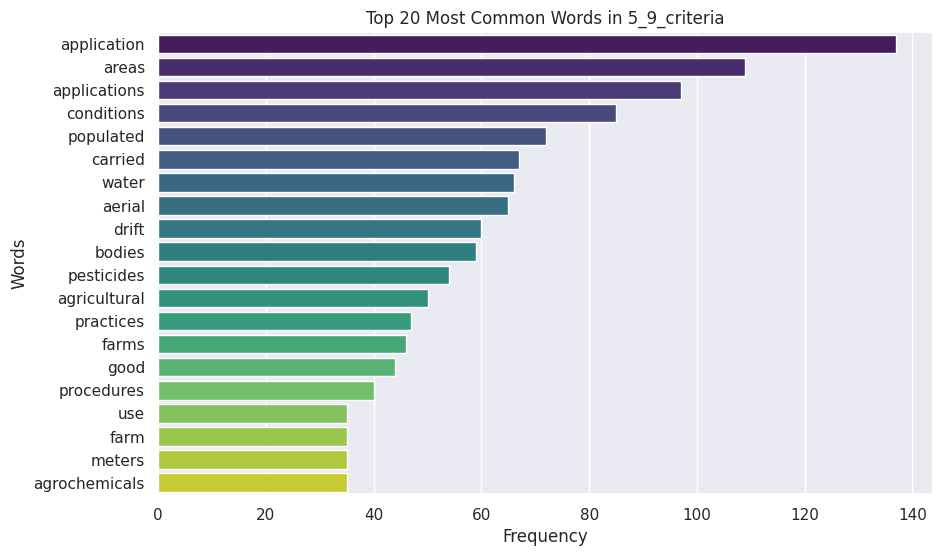

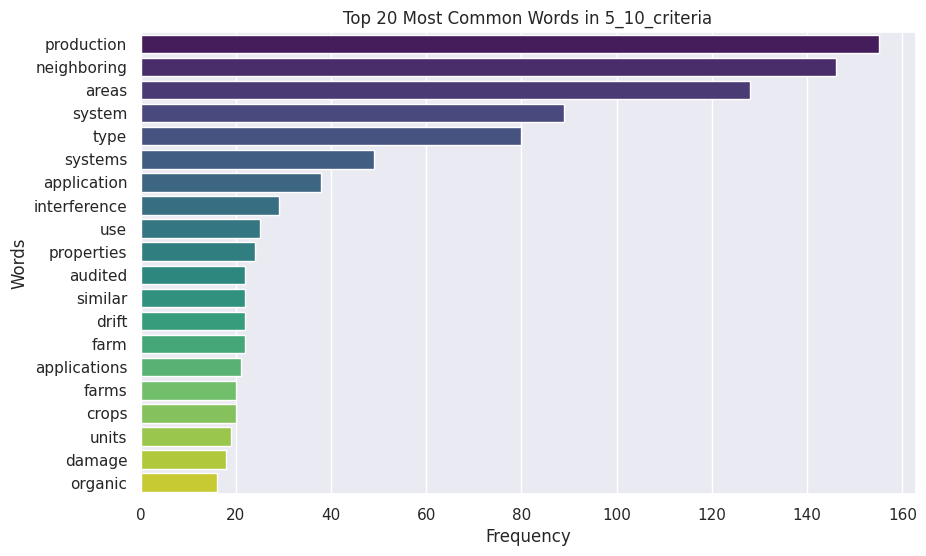

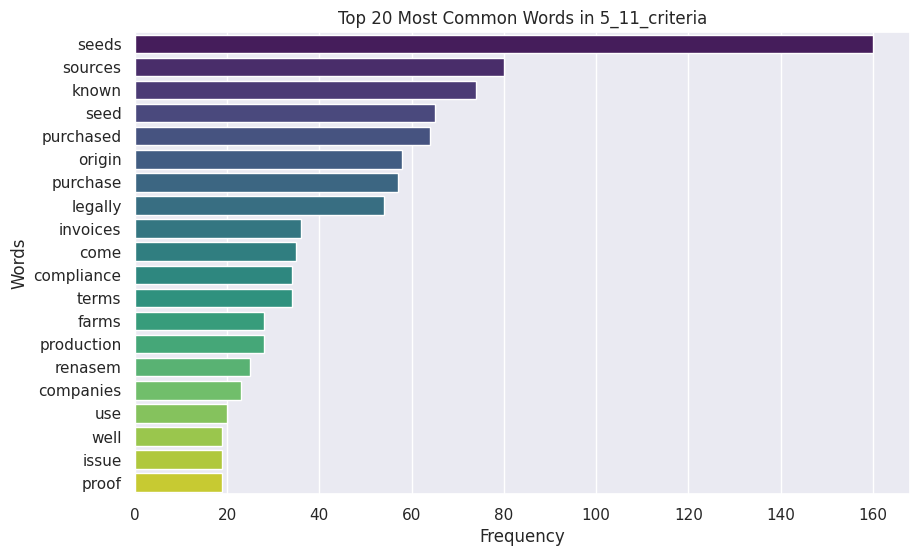

In [16]:
sns.set(style="darkgrid")

def plot_word_frequency_histograms(freq_dict):
    for column, freq in freq_dict.items():
        # Pegar as 20 palavras mais comuns
        common_words = freq.most_common(20)
        words = [word[0] for word in common_words]
        counts = [word[1] for word in common_words]

        # Criar o histograma
        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts, y=words, palette="viridis")
        plt.title(f"Top 20 Most Common Words in {column}")
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.show()

plot_word_frequency_histograms(word_freqs)

In [17]:
def lexical_diversity(df):
    diversity_results = []

    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)).lower())
        diversity = len(set(words)) / len(words) if words else 0
        diversity_results.append([column, diversity])

    return pd.DataFrame(diversity_results, columns=["Column", "Lexical Diversity"])

In [18]:
diversity_df = lexical_diversity(text_columns)

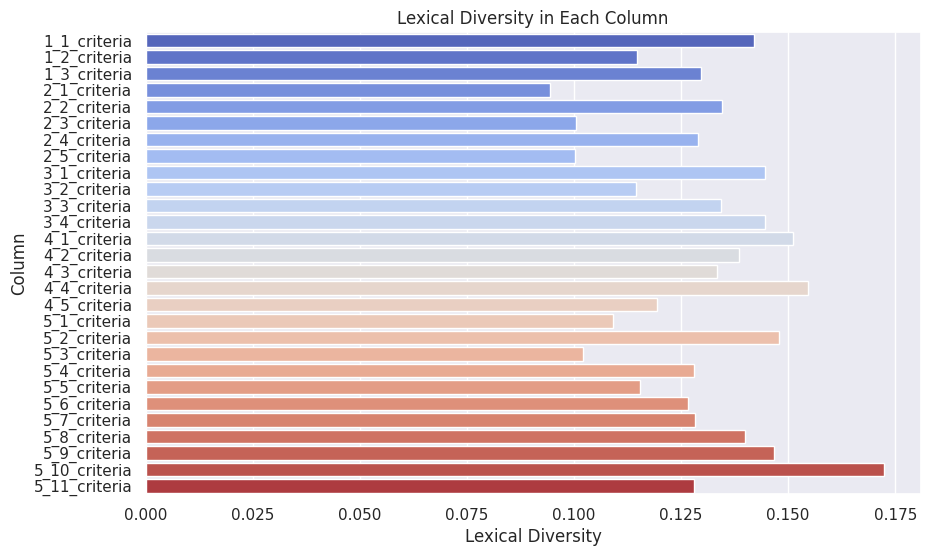

In [19]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="Lexical Diversity", y="Column", data=diversity_df, palette="coolwarm")
plt.title("Lexical Diversity in Each Column")
plt.xlabel("Lexical Diversity")
plt.ylabel("Column")
plt.show()

# n-grams analysis

In [20]:
def get_ngrams(df, n=2):
    all_ngrams = []
    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)).lower())
        n_grams = ngrams(words, n)
        ngrams_freq = Counter(n_grams).most_common(10)

        for ngram, freq in ngrams_freq:
            all_ngrams.append([column, ' '.join(ngram), freq])

    return pd.DataFrame(all_ngrams, columns=["Column", "N-Gram", "Frequency"])

In [21]:
bigrams_df = get_ngrams(text_columns, 2)

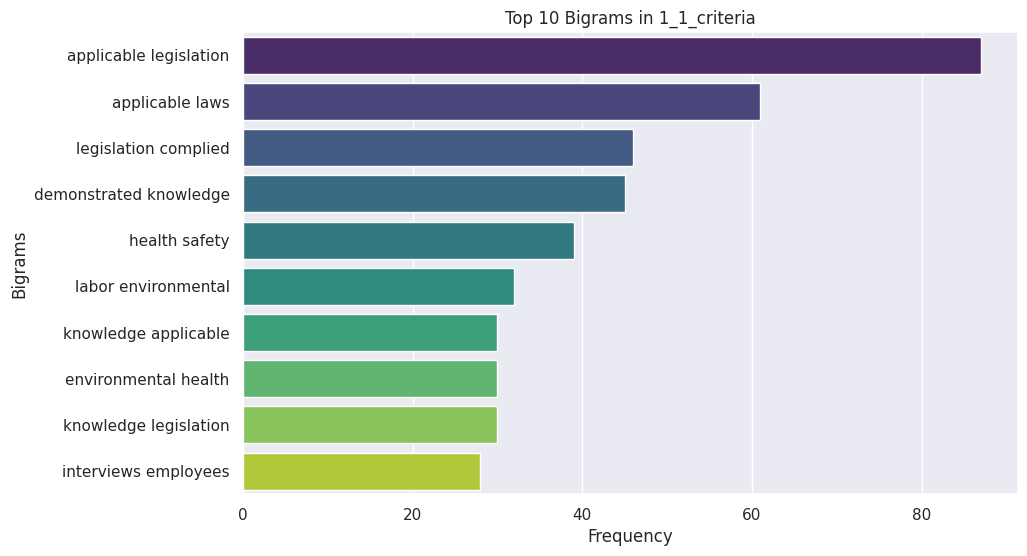

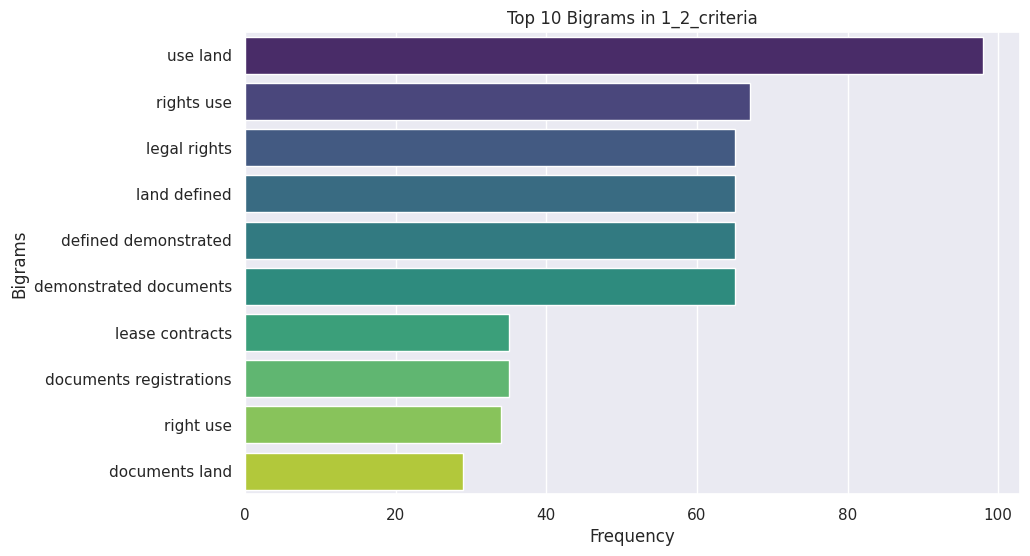

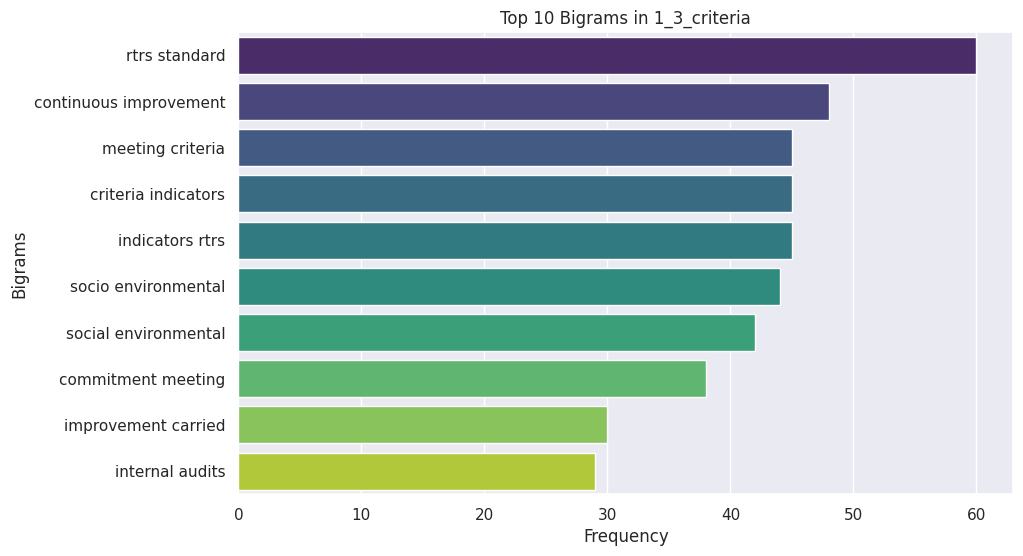

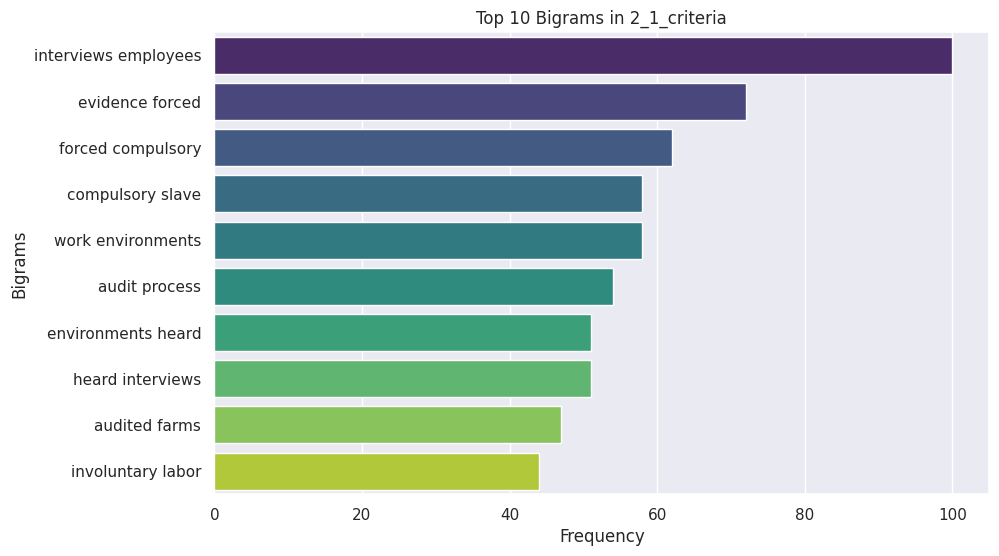

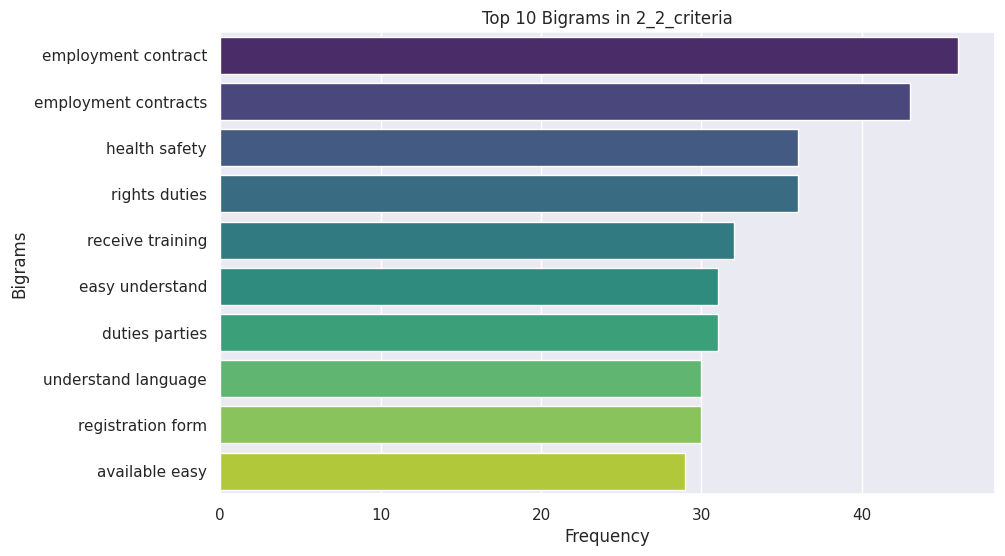

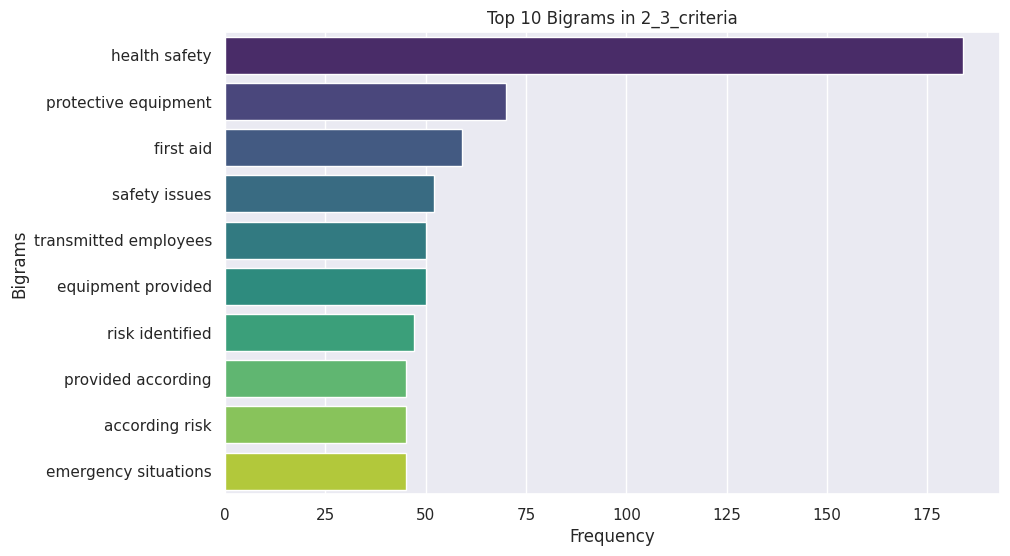

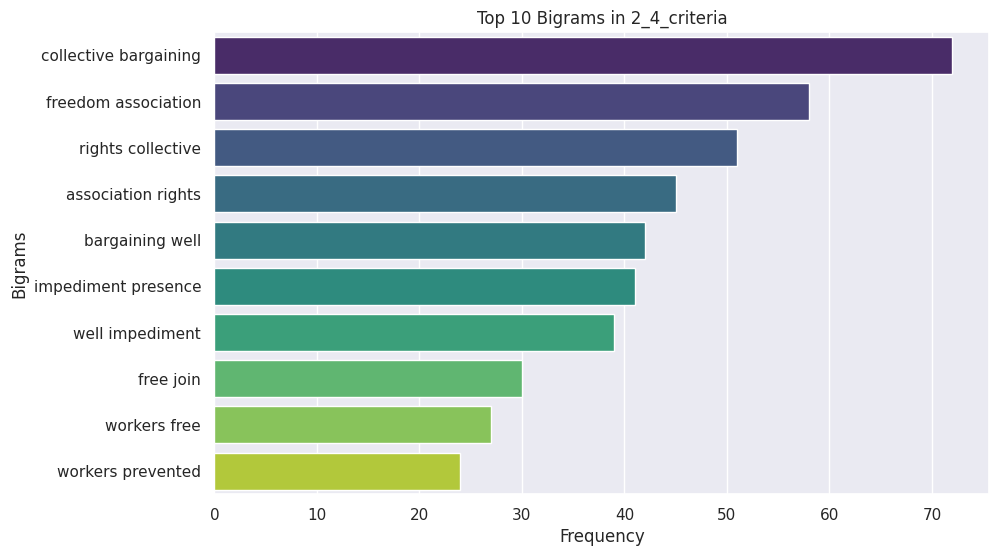

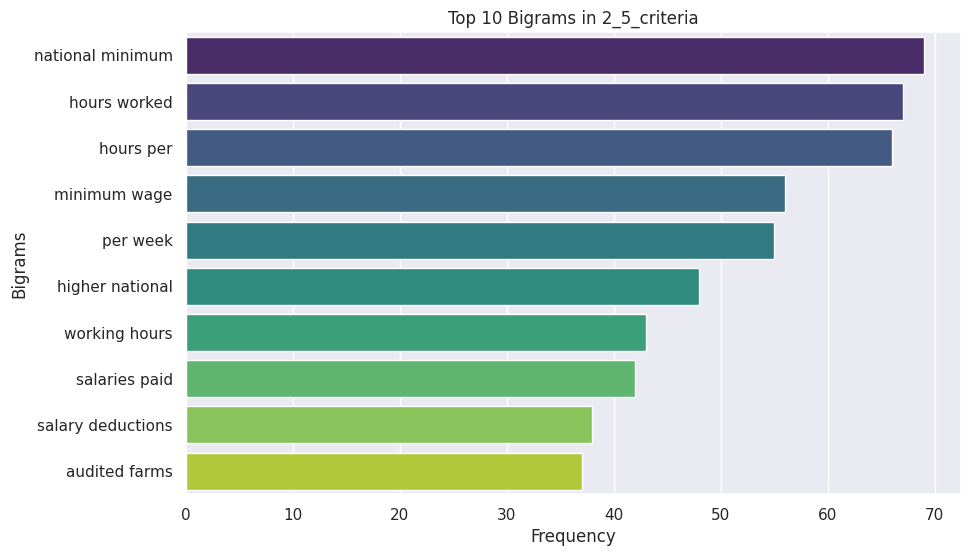

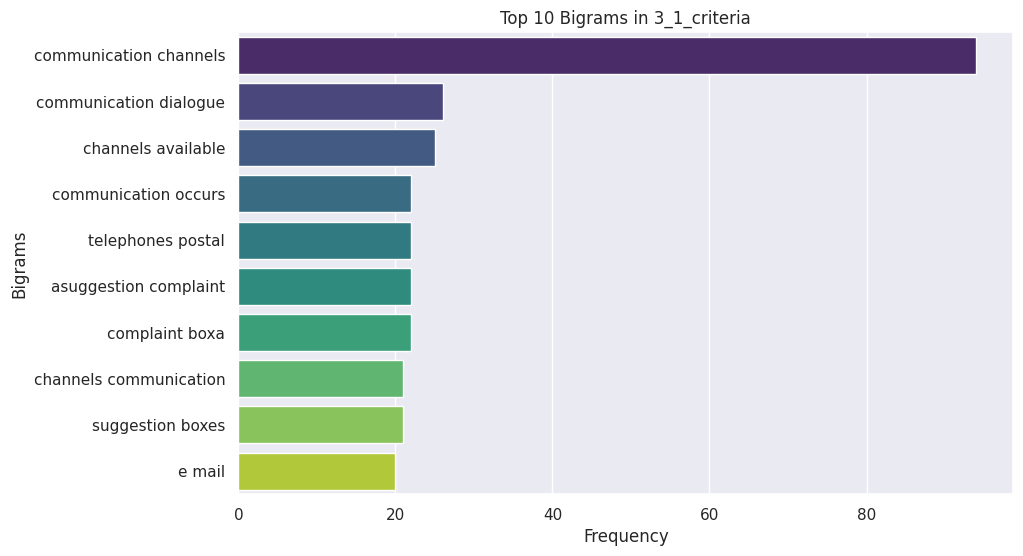

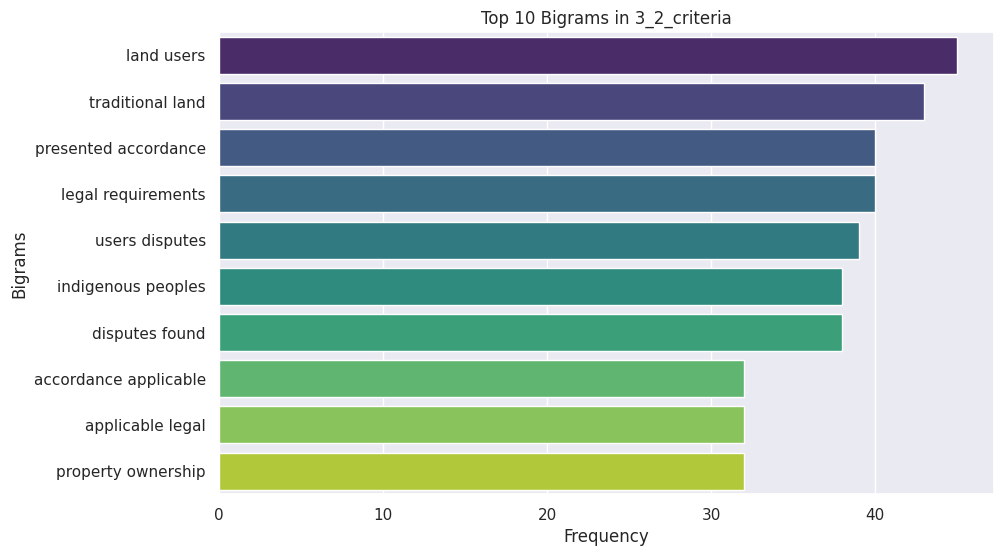

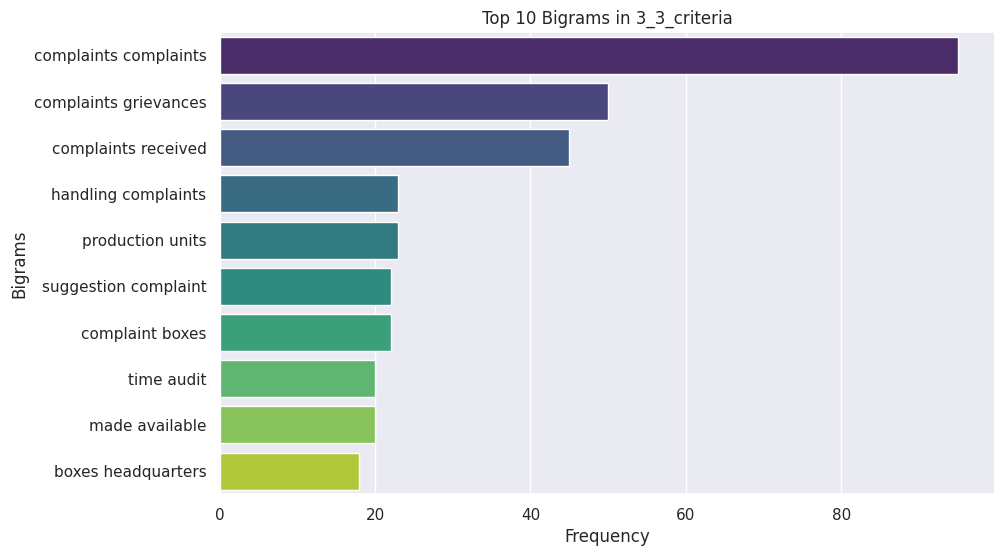

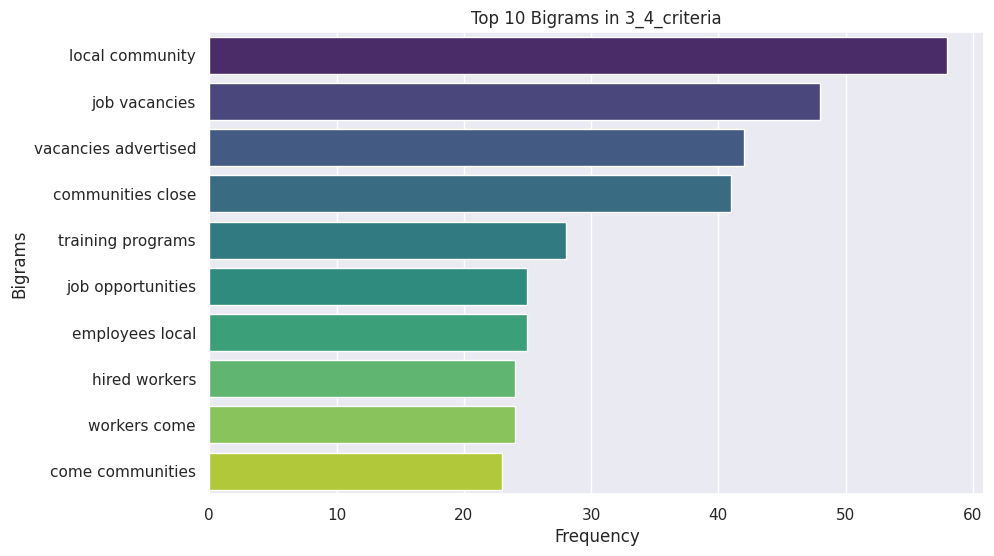

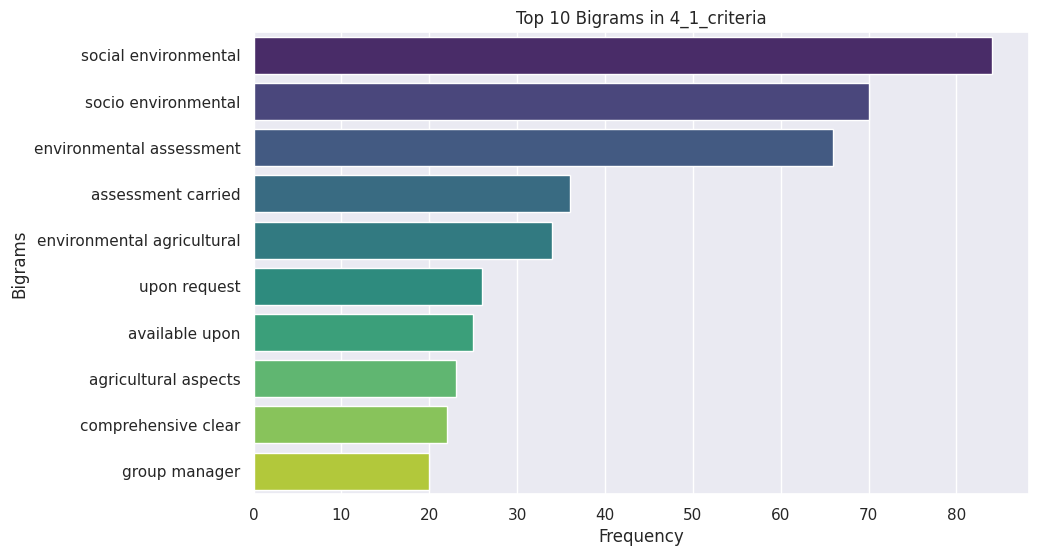

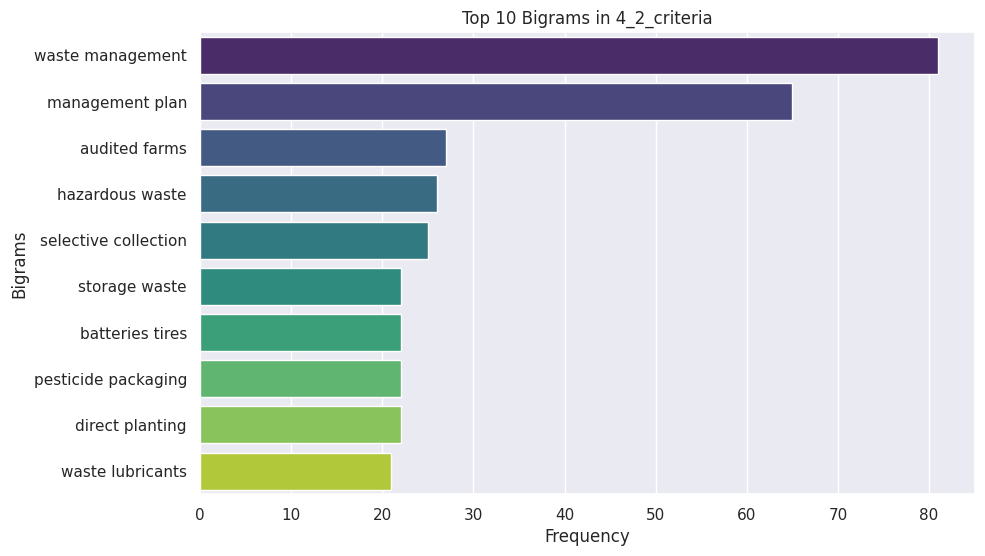

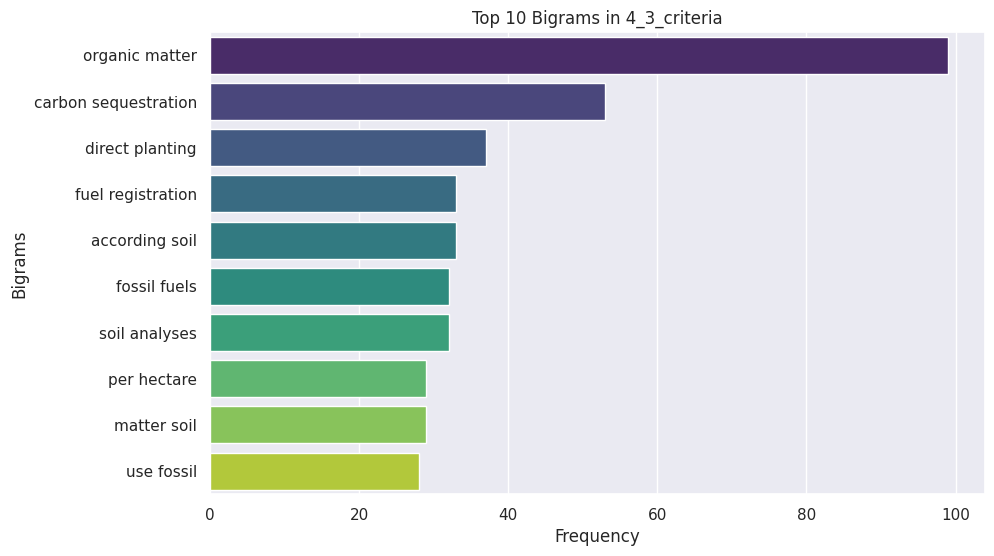

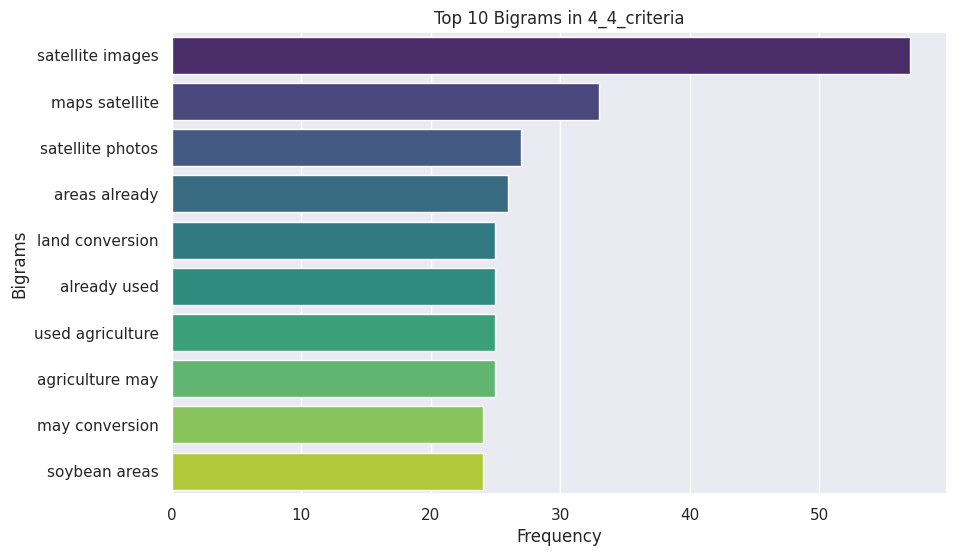

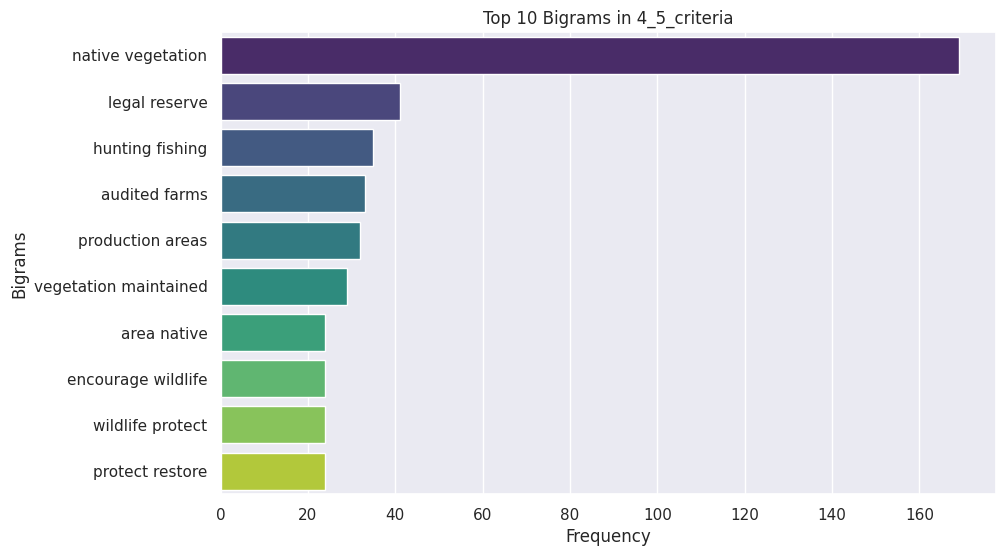

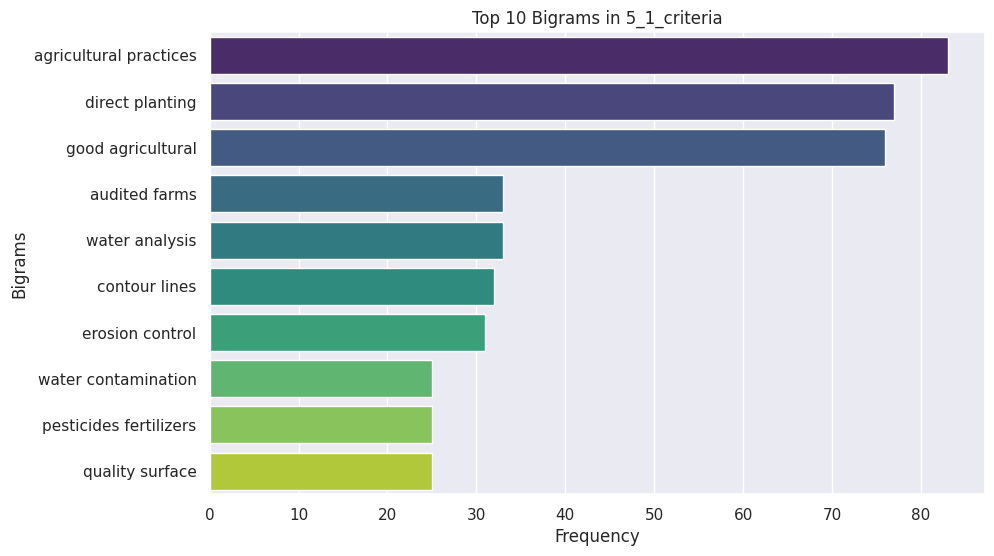

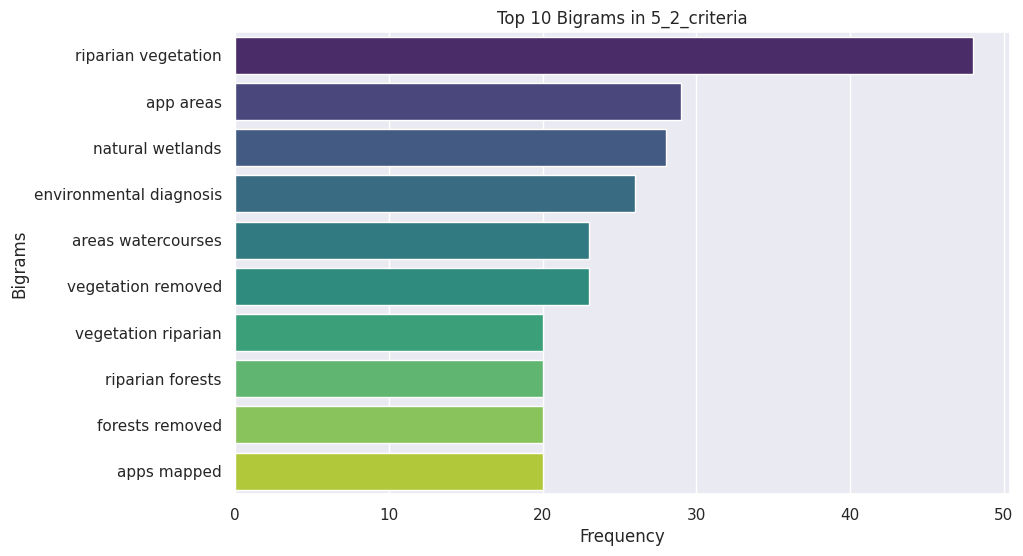

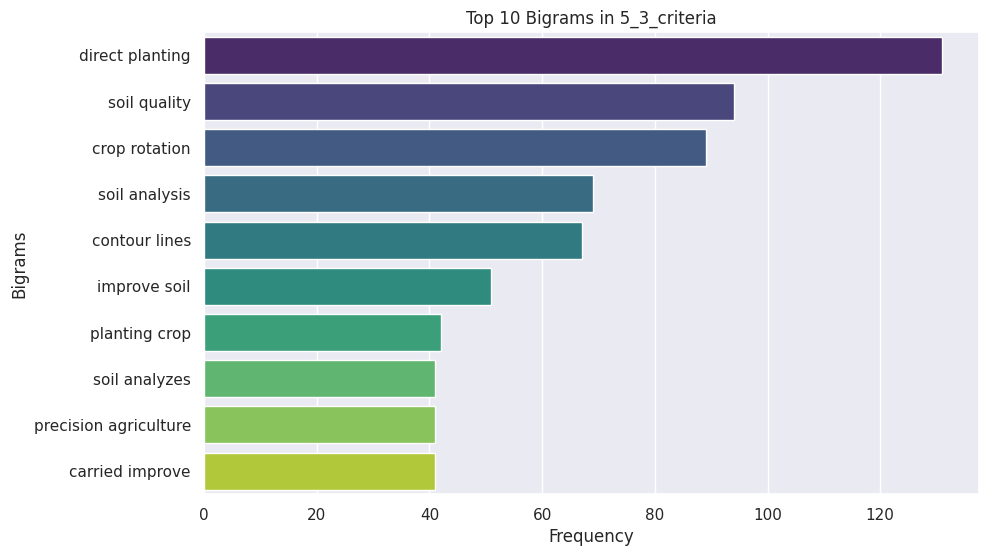

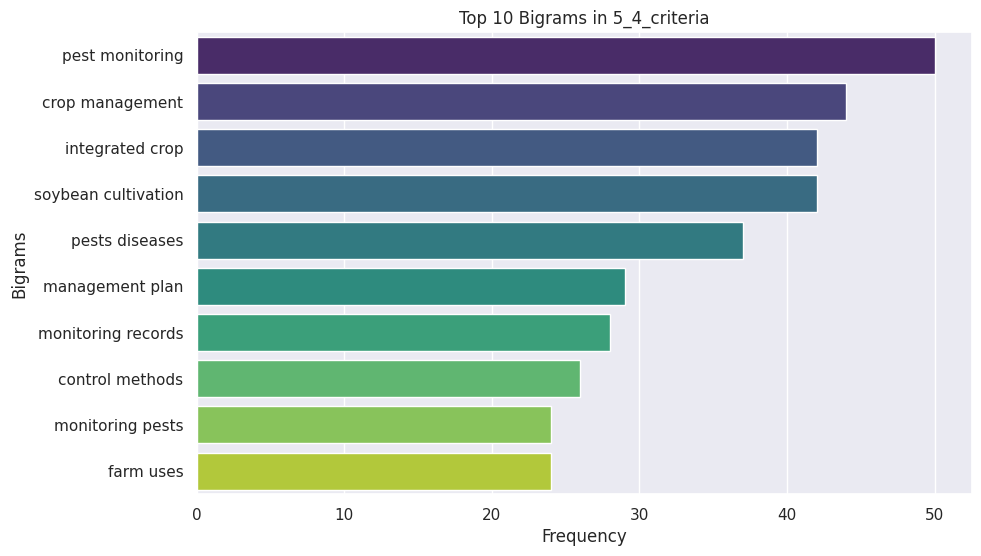

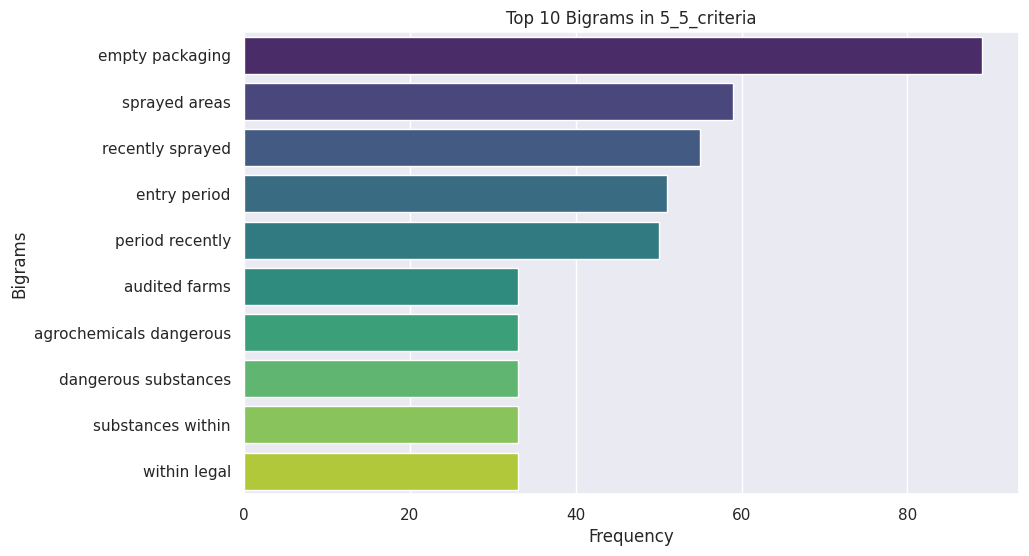

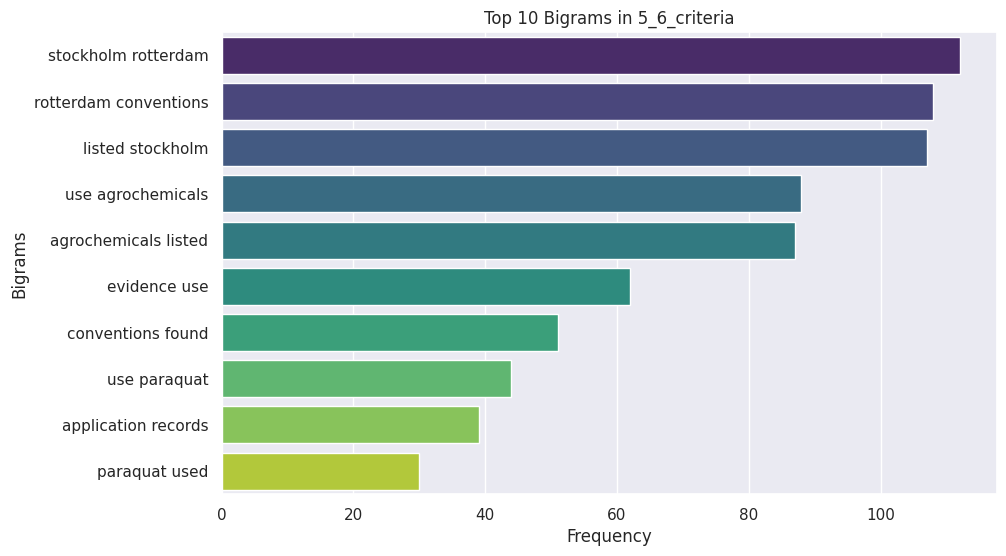

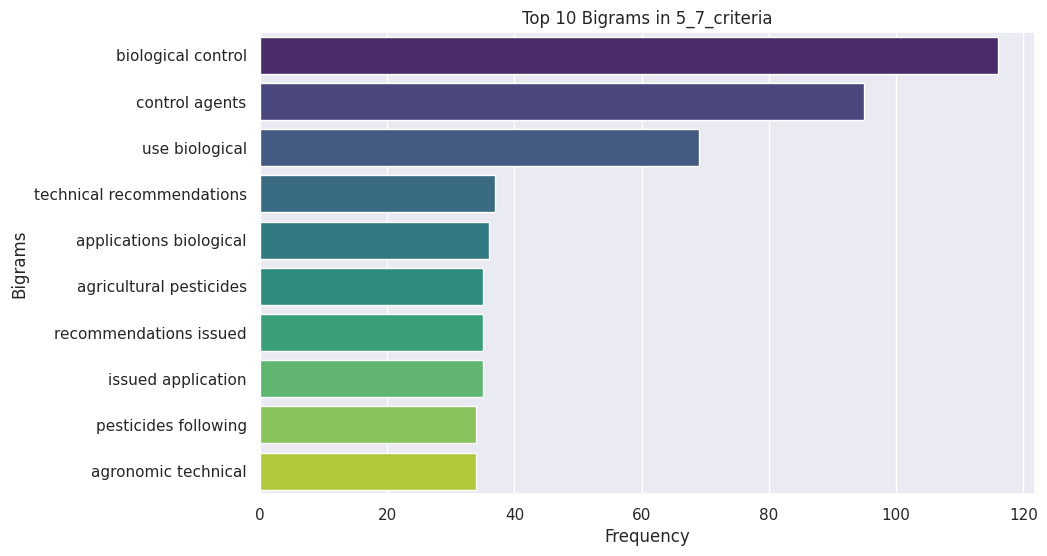

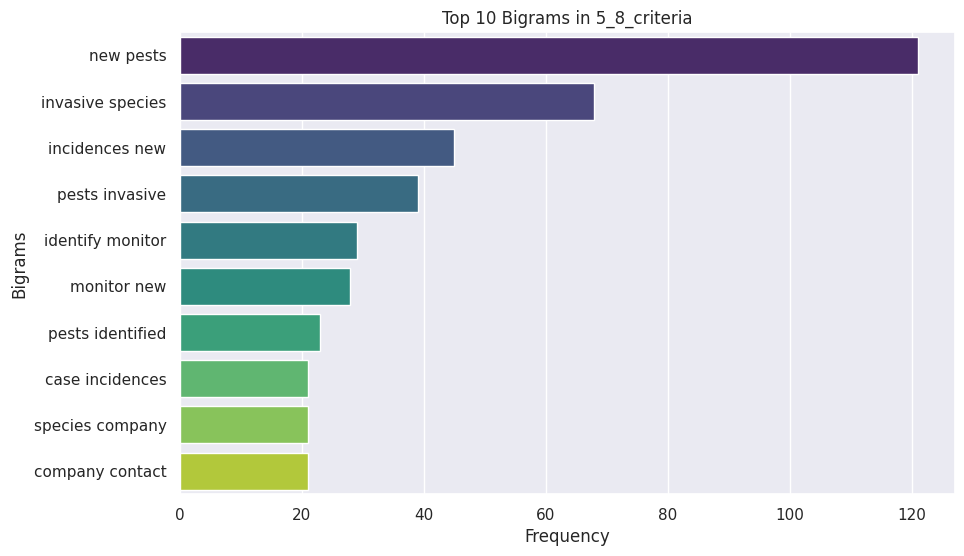

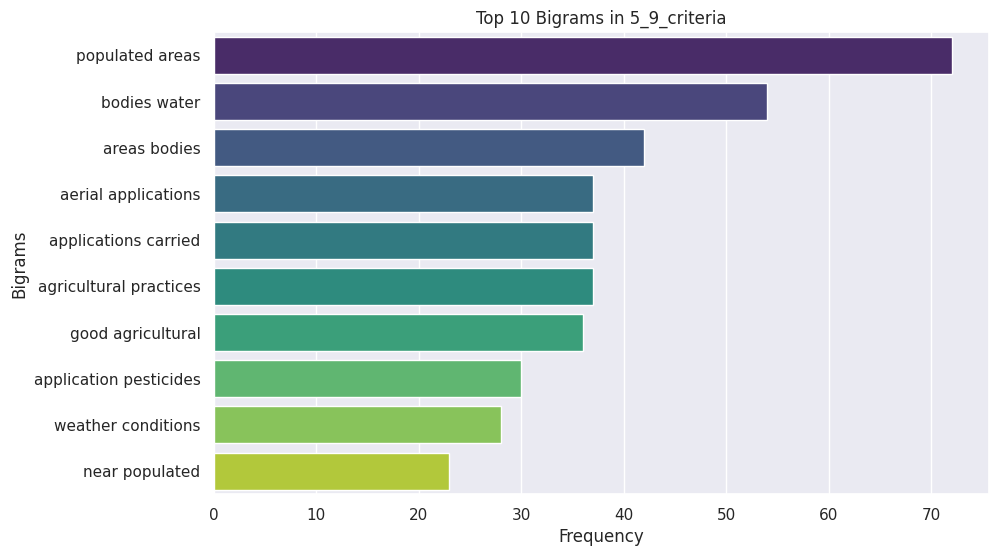

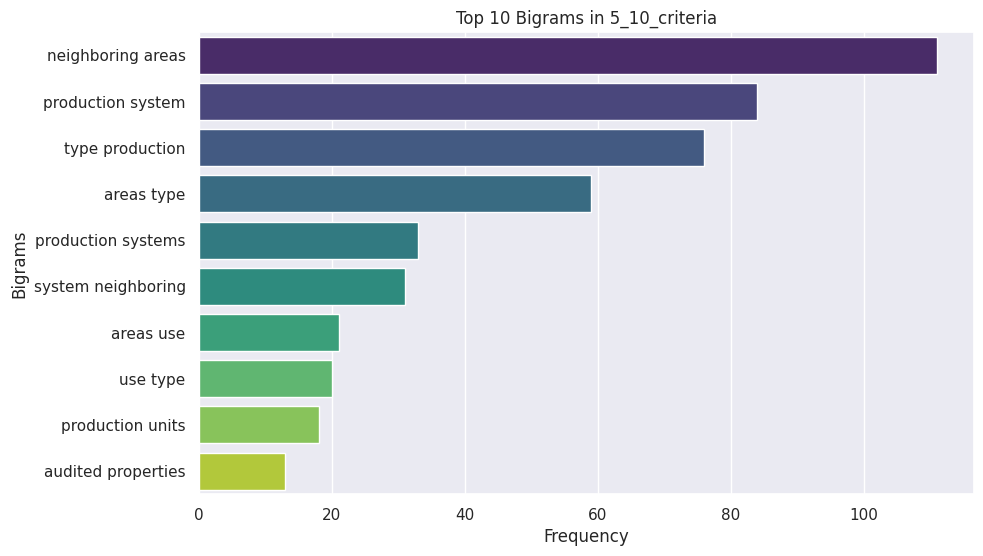

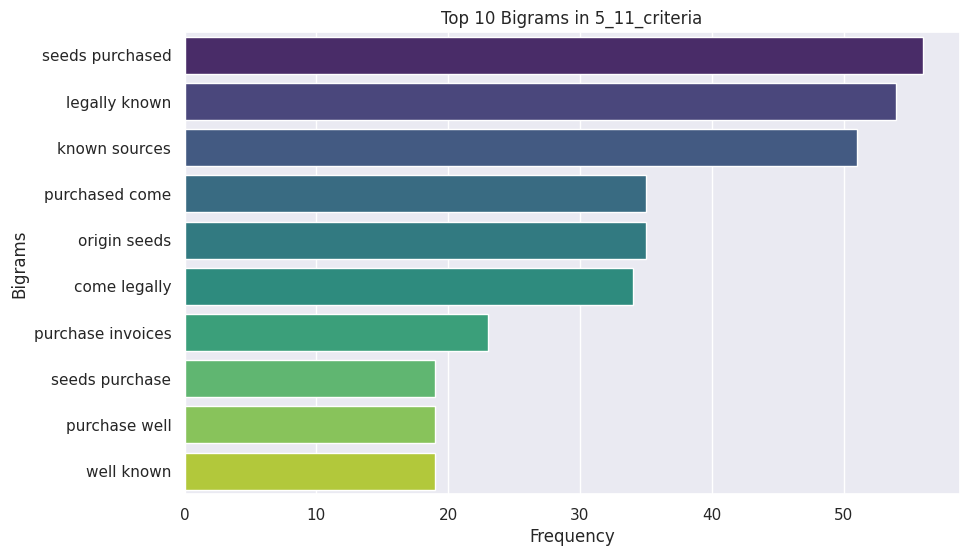

In [22]:
sns.set(style="darkgrid")

def plot_ngrams(df):
    columns = df['Column'].unique()
    for column in columns:
        sub_df = df[df['Column'] == column]
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Frequency", y="N-Gram", data=sub_df, palette="viridis")
        plt.title(f"Top 10 Bigrams in {column}")
        plt.xlabel("Frequency")
        plt.ylabel("Bigrams")
        plt.show()

plot_ngrams(bigrams_df)

# Sentiment Polarity Analysis (TextBlop)

In [23]:
from textblob import TextBlob

def sentiment_analysis(df):
    sentiment_results = []
    for column in df.columns:
        text = ' '.join(df[column].dropna().astype(str))
        blob = TextBlob(text)
        sentiment = blob.sentiment.polarity
        sentiment_results.append([column, sentiment])
    return pd.DataFrame(sentiment_results, columns=["Column", "Polarity"])

In [24]:
sentiment_df = sentiment_analysis(text_columns)

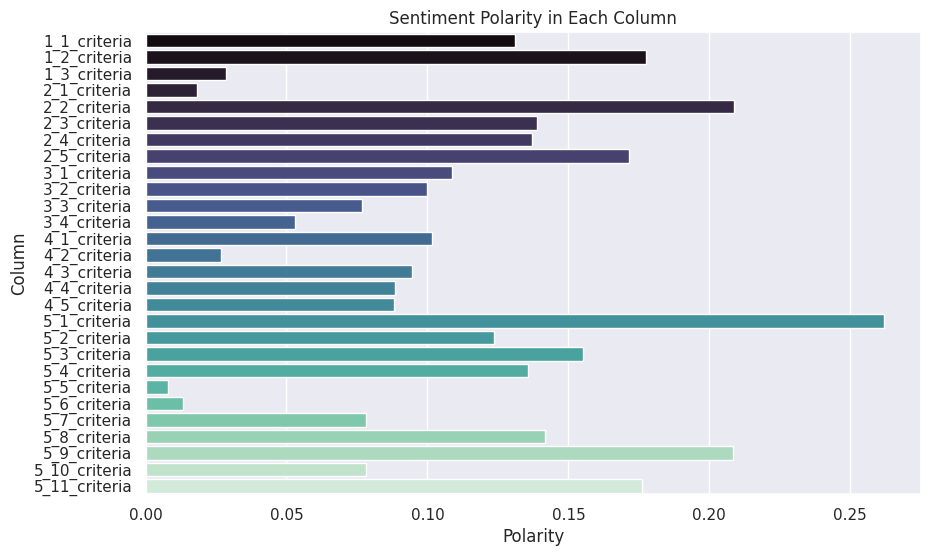

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Polarity", y="Column", data=sentiment_df, palette="mako")
plt.title("Sentiment Polarity in Each Column")
plt.xlabel("Polarity")
plt.ylabel("Column")
plt.show()

# Audit Reports Sentiment Analisys without fine-tuning w/ BERT



In [26]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

def evaluate_sentiment(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation = True)
    with torch.no_grad():
        outputs = model(**inputs)

    sentiment_class = outputs.logits.argmax().item()
    sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
    sentiment = sentiment_labels[sentiment_class]
    return sentiment

In [27]:
sentence = "The report highlights several environmental concerns."
print(evaluate_sentiment(sentence))

Positive


In [28]:
cols = text_columns.columns 
rtrs_sentiment_analysis = pd.DataFrame(columns=cols)

for i in tqdm(cols):
    rtrs_sentiment_analysis[i] = text_columns[i].map(lambda x: evaluate_sentiment(x))

100%|██████████| 28/28 [06:51<00:00, 14.70s/it]


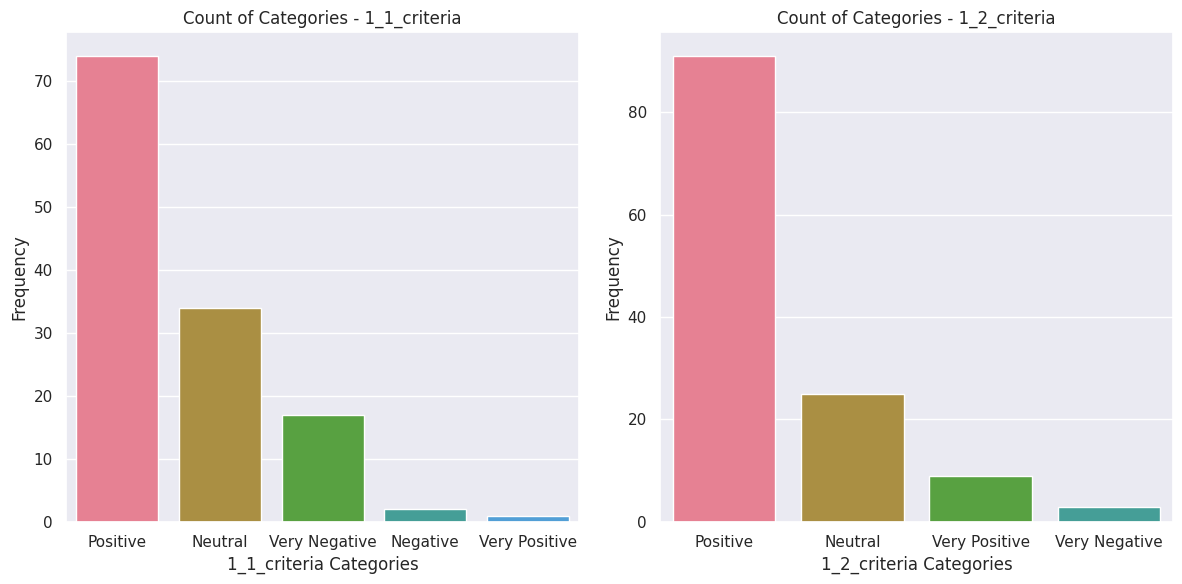

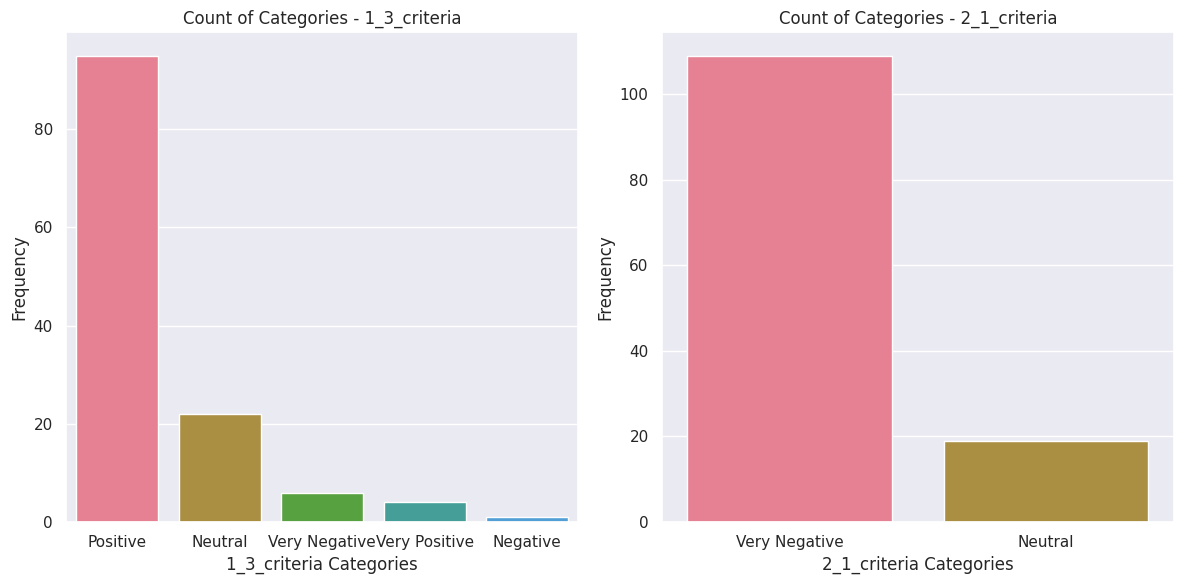

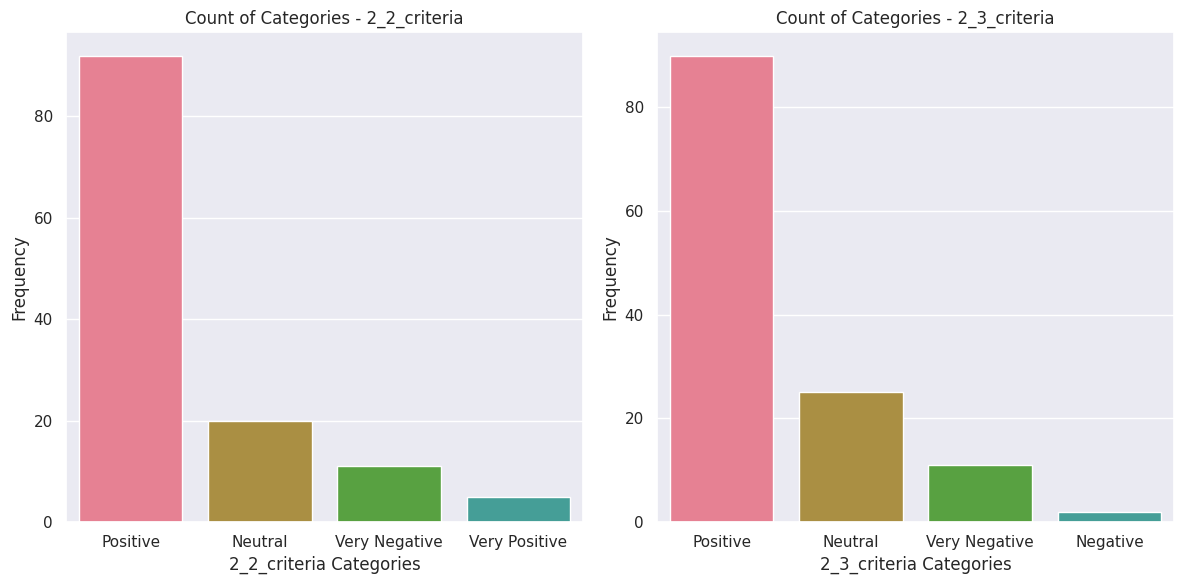

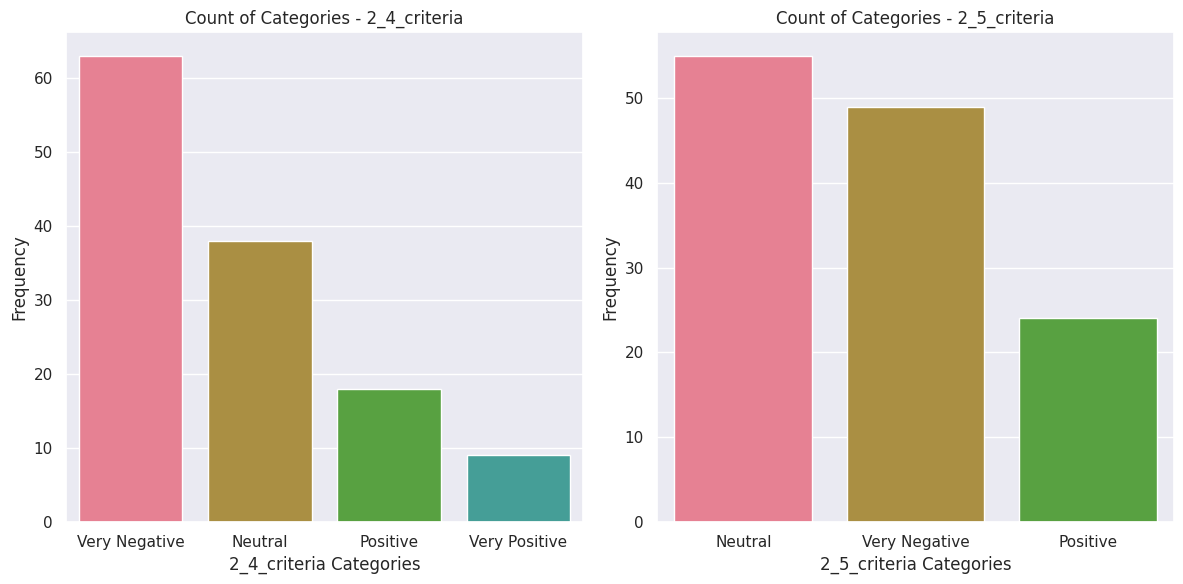

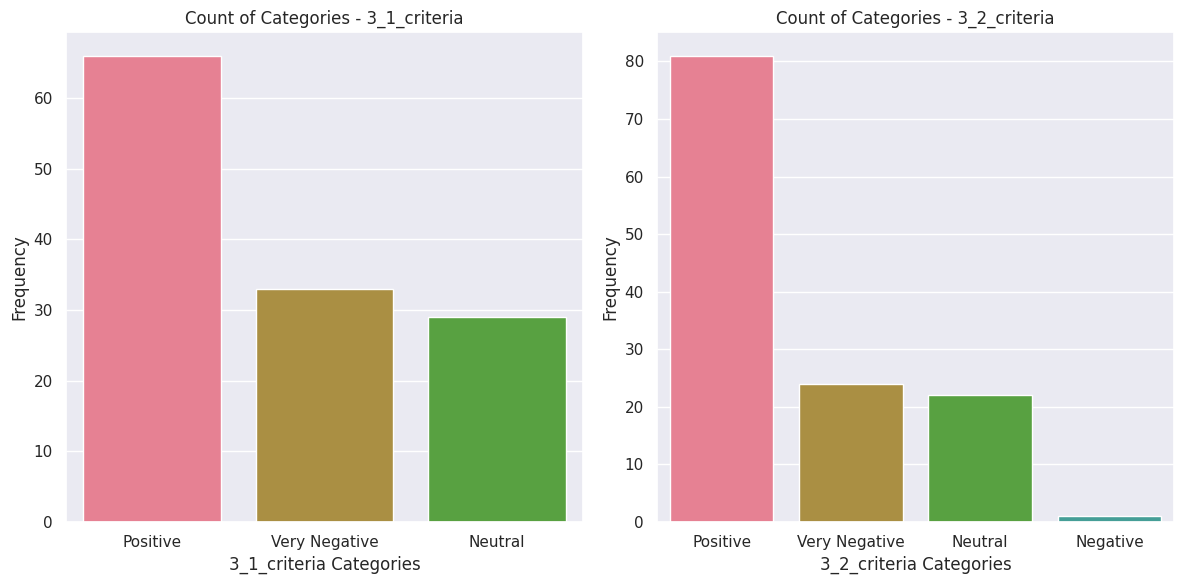

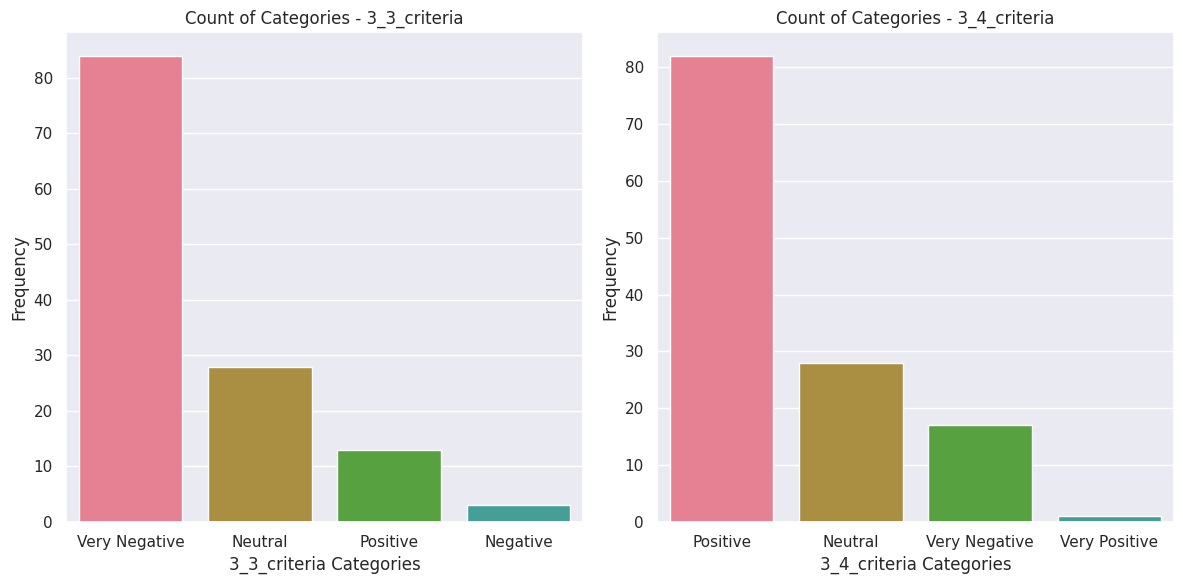

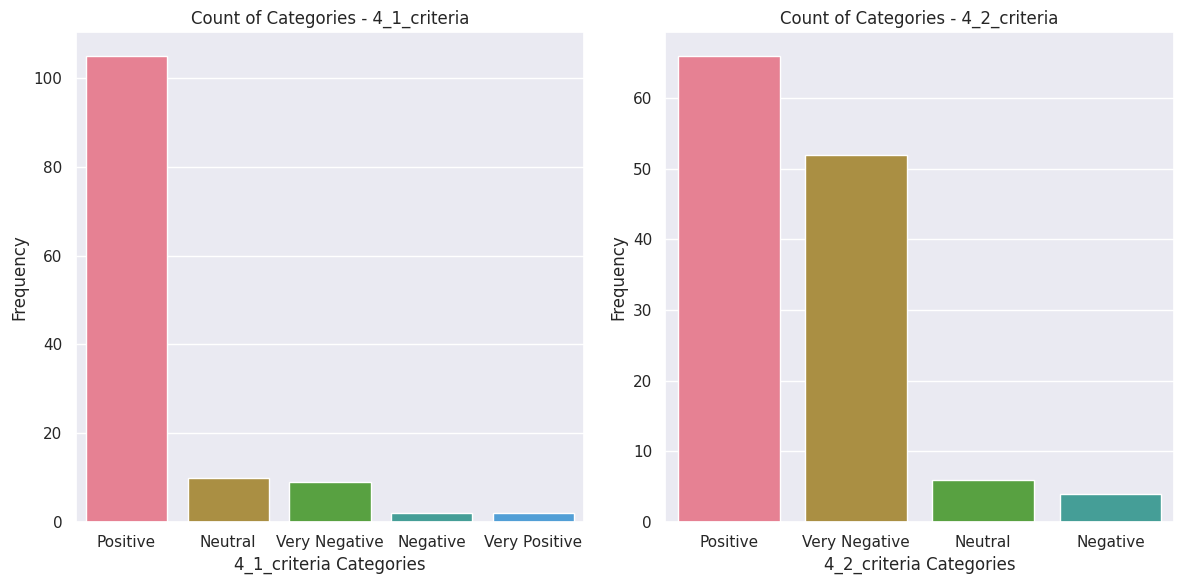

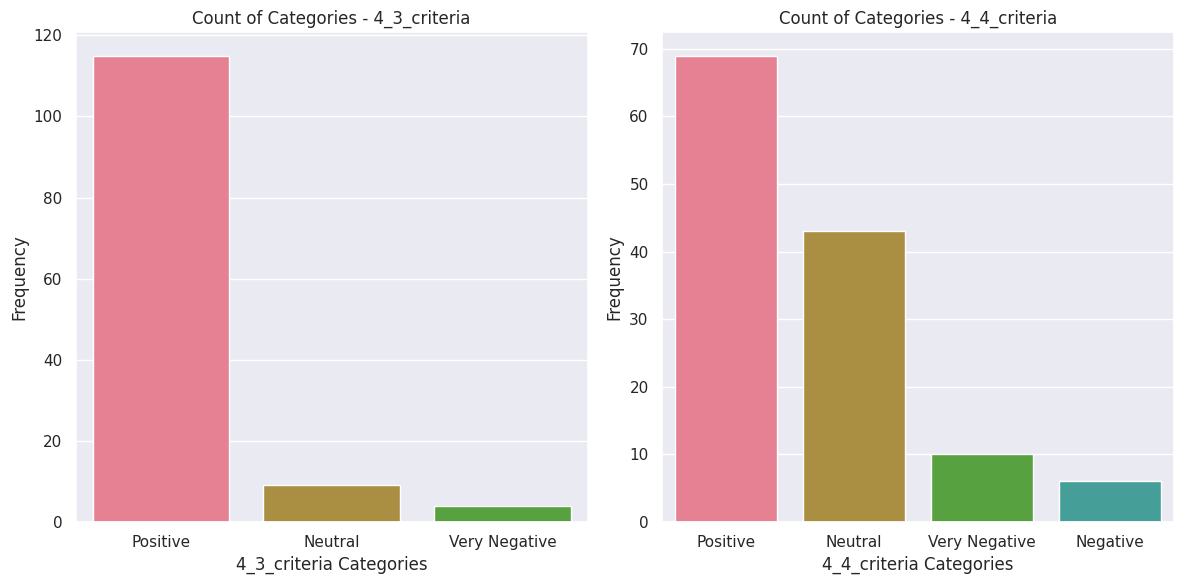

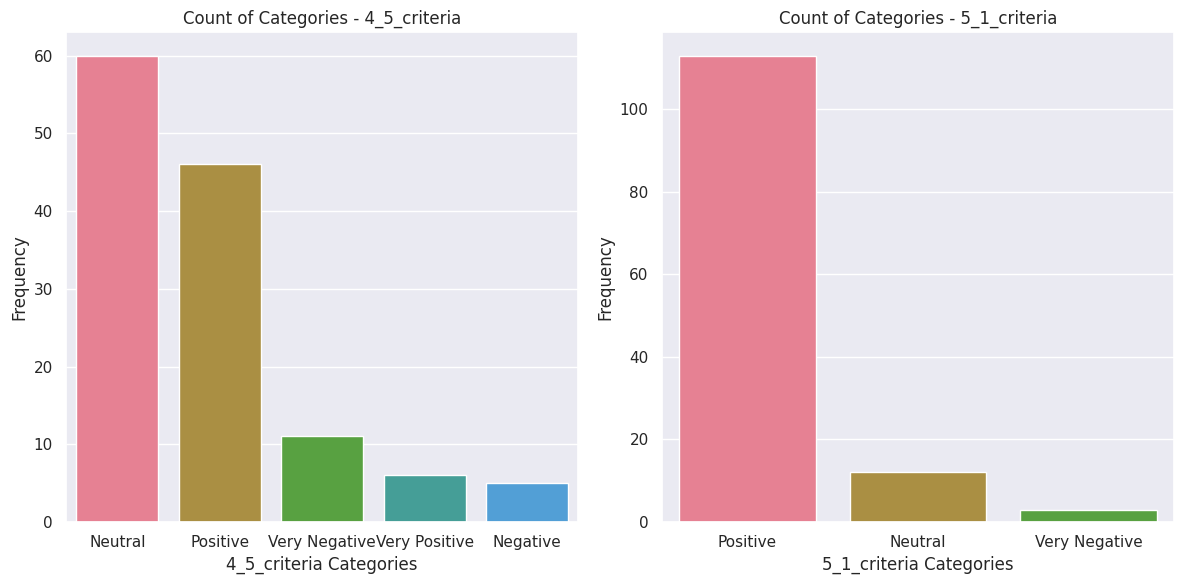

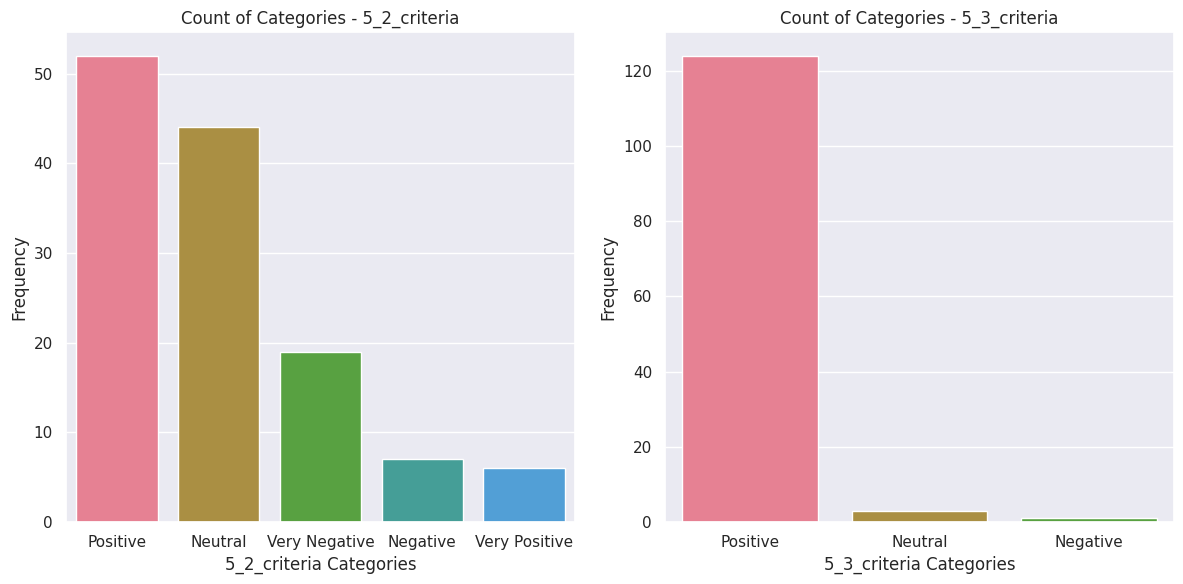

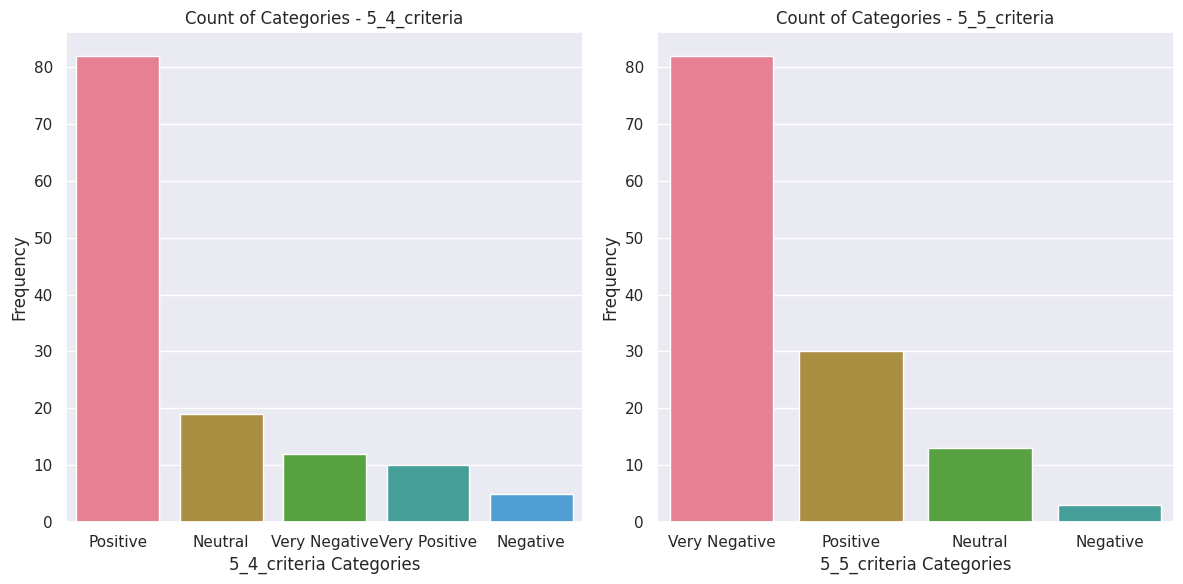

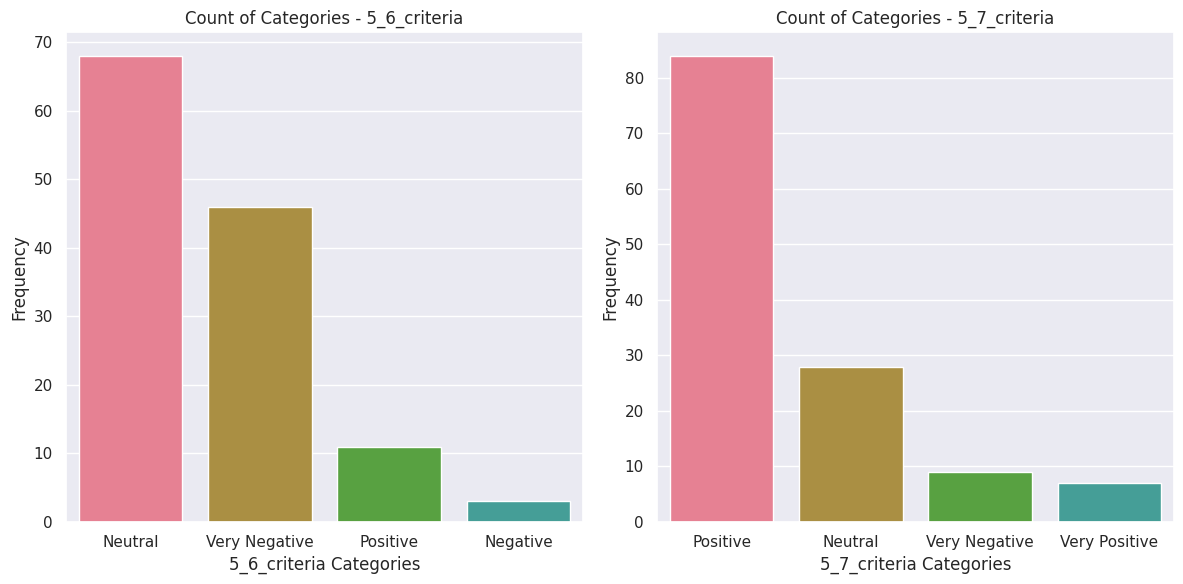

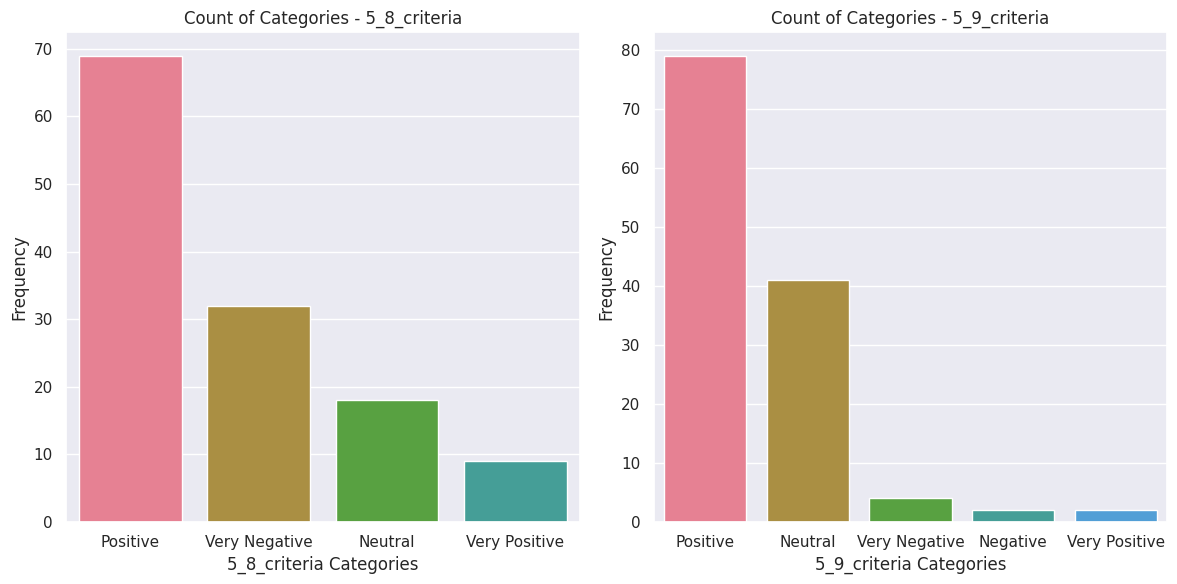

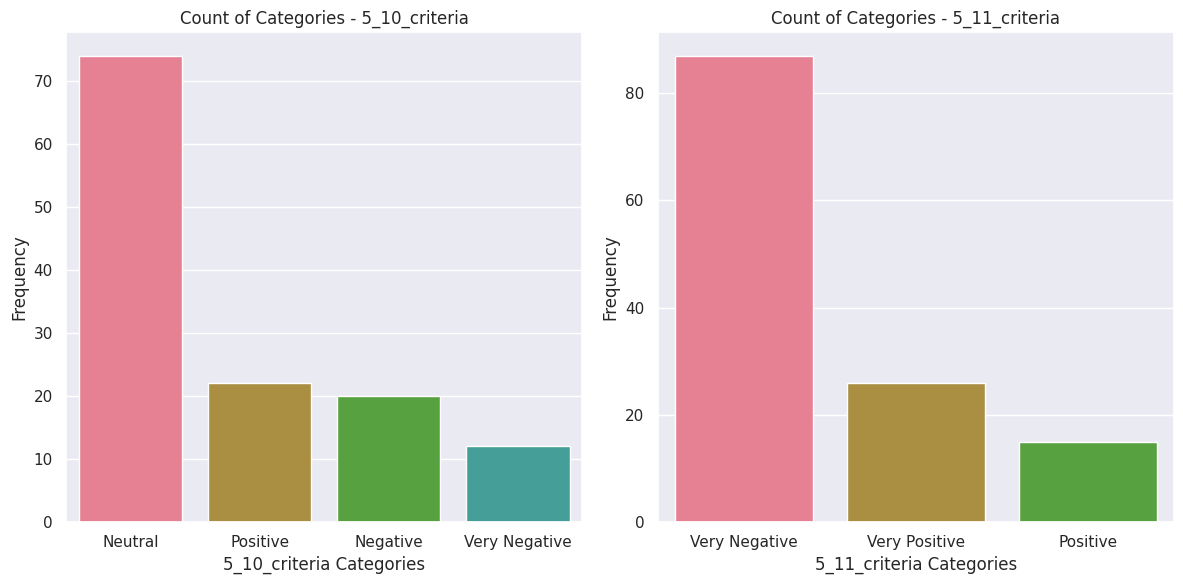

In [29]:
columns_to_plot = rtrs_sentiment_analysis.columns
num_plots = len(columns_to_plot)
rows = (num_plots + 1) // 2

sns.set_palette("husl")

for i in range(0, len(columns_to_plot), 2):
    plt.figure(figsize=(12, 6))
    
    for j in range(2):
        if i + j < len(columns_to_plot):
            col = columns_to_plot[i + j]
            frequencia = rtrs_sentiment_analysis[col].value_counts()
            
            plt.subplot(1, 2, j + 1)
            sns.barplot(x=frequencia.index, y=frequencia.values)
            plt.xlabel(f'{col} Categories')
            plt.ylabel('Frequency')
            plt.title(f'Count of Categories - {col}')
    
    plt.tight_layout()
    plt.show()

In [30]:
#Encode 
feeling_map = {
    "Very Negative": -2,
    "Negative": -1,
    "Neutral": 0,
    "Positive": 1,
    "Very Positive": 2
}

for col in rtrs_sentiment_analysis:
    rtrs_sentiment_analysis[col] = rtrs_sentiment_analysis[col].map(feeling_map)

In [31]:
rtrs_sentiment_analysis.head(4)

1_1_criteria  1_2_criteria  1_3_criteria  2_1_criteria  2_2_criteria  \
0             1             1             1            -2             1   
1            -2             0             1            -2             1   
2             1             0             1            -2             0   
3             1             1             1            -2             1   

   2_3_criteria  2_4_criteria  2_5_criteria  3_1_criteria  3_2_criteria  ...  \
0             1            -2            -2             0            -2  ...   
1             0            -2            -2            -2             0  ...   
2             1             0             0             0             1  ...   
3             1             0            -2             1             1  ...   

   5_2_criteria  5_3_criteria  5_4_criteria  5_5_criteria  5_6_criteria  \
0             1             1            -2            -2             1   
1             1             1             0            -2            -2   
2             1             1             1            -2            -2   
3            -2             1             1            -2             1   

   5_7_criteria  5_8_criteria  5_9_criteria  5_10_criteria  5_11_criteria  
0             1            -2             0              1             -2  
1             1            -2            -2             -1             -2  
2             1             0             0              0             -2  
3             1             1             0              1              1  

[4 rows x 28 columns]

In [32]:
rtrs_sentiment_analysis['score_per_enterprise'] = rtrs_sentiment_analysis.sum(axis=1)

In [33]:
rtrs_sentiment_analysis['Organization'] = rtrs_df['Organization'].copy(deep=True)

In [34]:
enterprises = rtrs_sentiment_analysis[['Organization', 'score_per_enterprise']]
enterprises_sorted = enterprises.sort_values(by='score_per_enterprise')

In [35]:
enterprises_sorted.to_csv('enterprise_sorted.csv')

In [36]:
enterprises_sorted.head(15)

Organization  score_per_enterprise
31                                               Bunge                   -26
101                             Louis Dreyfus Company                    -25
38                              Louis Dreyfus Company                    -23
73                              Louis Dreyfus Company                    -22
102                                    Agrex do Brasil                   -21
1    Fundação de Apoio à Pesquisa do Corredor de Ex...                   -18
125                                             Amaggi                   -17
4                           Tecnosol Consultoria Rural                   -17
117                                             Amaggi                   -15
7                 Archer-Daniels-Midland Company (ADM)                   -15
69                                     Agrex do Brasil                   -15
51                                     Agrex do Brasil                   -12
115                  Associação Clube Amigos da Terra                    -12
89                   Associação Clube Amigos da Terra                    -12
22                                        SLC Agrícola                   -10

In [37]:
enterprises_sorted.tail(15)

Organization  score_per_enterprise
93                                     Grupo Reinhofer                    16
86                                      Fazenda Aurora                    17
123  Cerquality Consultoria em Sustentabilidade e C...                    18
108                               Bartira Agropecuária                    19
59                                Bartira Agropecuária                    19
99                                Bartira Agropecuária                    19
60                                Bartira Agropecuária                    19
55                                Bartira Agropecuária                    19
82                                    Grupo Hervalense                    20
45                                    Grupo Hervalense                    20
18                                    Grupo Hervalense                    20
48                              O Telhar Agropecuária                     24
104                             O Telhar Agropecuária                     24
79                              O Telhar Agropecuária                     24
103                                           GGF Agro                    24

In [38]:
rtrs_sentiment_analysis.iloc[:, :-1]

1_1_criteria  1_2_criteria  1_3_criteria  2_1_criteria  2_2_criteria  \
0               1             1             1            -2             1   
1              -2             0             1            -2             1   
2               1             0             1            -2             0   
3               1             1             1            -2             1   
4              -2             1            -2            -2             0   
..            ...           ...           ...           ...           ...   
123             1             1             1            -2             1   
124             1             1             1            -2            -2   
125            -2             2             0            -2             1   
126             1             1             1            -2             0   
127             1             1             1            -2             1   

     2_3_criteria  2_4_criteria  2_5_criteria  3_1_criteria  3_2_criteria  \
0               1            -2            -2             0            -2   
1               0            -2            -2            -2             0   
2               1             0             0             0             1   
3               1             0            -2             1             1   
4               0            -2            -2            -2            -2   
..            ...           ...           ...           ...           ...   
123             1             1             1             1             1   
124             1             0             0             0             1   
125            -2            -2            -2             0             0   
126             1            -2            -2             1             1   
127             0            -2             0            -2             1   

     ...  5_3_criteria  5_4_criteria  5_5_criteria  5_6_criteria  \
0    ...             1            -2            -2             1   
1    ...             1             0            -2            -2   
2    ...             1             1            -2            -2   
3    ...             1             1            -2             1   
4    ...             1            -2            -2             1   
..   ...           ...           ...           ...           ...   
123  ...             1             1            -2             0   
124  ...             1             1             1            -2   
125  ...             1             0            -2             0   
126  ...             1             0            -2             0   
127  ...             1             1            -2            -2   

     5_7_criteria  5_8_criteria  5_9_criteria  5_10_criteria  5_11_criteria  \
0               1            -2             0              1             -2   
1               1            -2            -2             -1             -2   
2               1             0             0              0             -2   
3               1             1             0              1              1   
4               1            -2            -2              1             -2   
..            ...           ...           ...            ...            ...   
123             2             1             1              0              2   
124             1             1             0              0             -2   
125             2            -2             0             -1             -2   
126            -2            -2             1             -1             -2   
127             1             1             1              0             -2   

     score_per_enterprise  
0                      -5  
1                     -18  
2                       2  
3                       7  
4                     -17  
..                    ...  
123                    18  
124                     5  
125                   -17  
126                    -8  
127                     0  

[128 rows x 29 columns]

In [39]:
score_per_criteria = rtrs_sentiment_analysis.iloc[:, :-1].copy(deep=True)

In [40]:
 df_score_criteria = score_per_criteria.sum(axis=0)

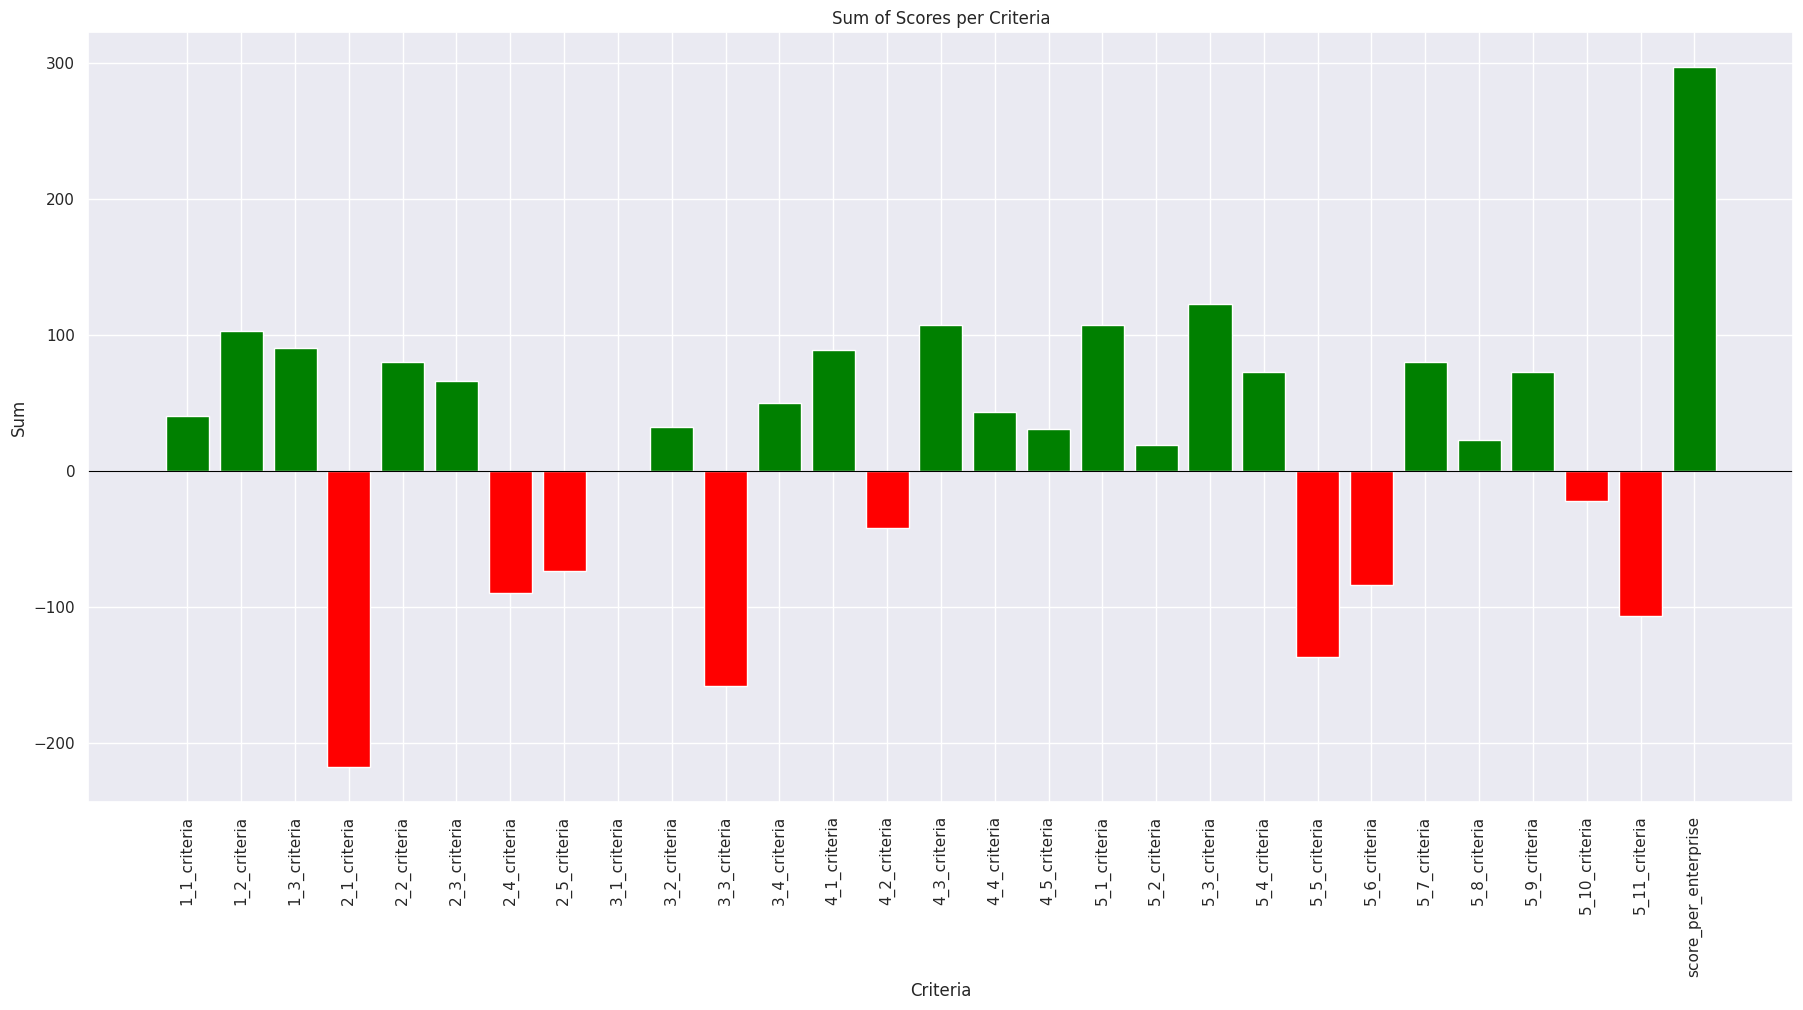

In [41]:
df_sum = pd.DataFrame(df_score_criteria, columns=['Sum'])

colors = ['green' if value >= 0 else 'red' for value in df_sum['Sum']]

plt.figure(figsize=(22, 10))
plt.bar(df_sum.index, df_sum['Sum'], color=colors)
plt.xlabel('Criteria')
plt.ylabel('Sum')
plt.title('Sum of Scores per Criteria')
plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0 for reference
plt.xticks(rotation='vertical')
plt.show()

In [42]:
df_sum.to_csv('score_per_criteria.csv')

# Farm Production Relevance

In [43]:
rtrs_df['Total_Farm_Area'] = rtrs_df['Total_Farm_Area'].str.replace(',', '.', regex=True)

In [44]:
rtrs_df['Total_Farm_Area'] = rtrs_df['Total_Farm_Area'].astype(float)

In [45]:
rtrs_sentiment_analysis['Yield'] = rtrs_df['Total_Production'] / rtrs_df['Total_Farm_Area']

In [46]:
rtrs_sentiment_analysis.columns

Index(['1_1_criteria', '1_2_criteria', '1_3_criteria', '2_1_criteria',
       '2_2_criteria', '2_3_criteria', '2_4_criteria', '2_5_criteria',
       '3_1_criteria', '3_2_criteria', '3_3_criteria', '3_4_criteria',
       '4_1_criteria', '4_2_criteria', '4_3_criteria', '4_4_criteria',
       '4_5_criteria', '5_1_criteria', '5_2_criteria', '5_3_criteria',
       '5_4_criteria', '5_5_criteria', '5_6_criteria', '5_7_criteria',
       '5_8_criteria', '5_9_criteria', '5_10_criteria', '5_11_criteria',
       'score_per_enterprise', 'Organization', 'Yield'],
      dtype='object')

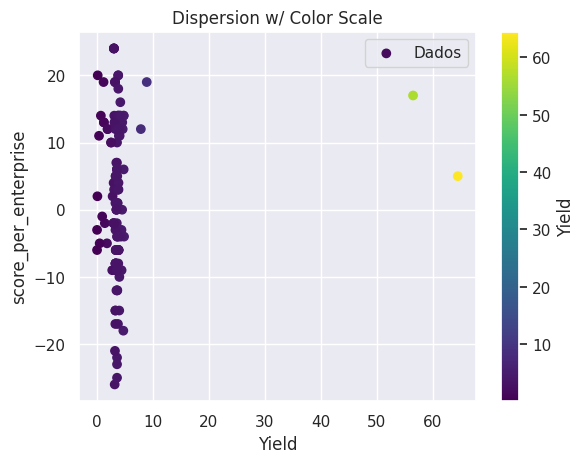

In [47]:
colormap = cm.viridis

sc = plt.scatter(
    rtrs_sentiment_analysis['Yield'],
    rtrs_sentiment_analysis['score_per_enterprise'],
    c=rtrs_sentiment_analysis['Yield'],  # Use 'Yield' para a escala de cor
    cmap=colormap,
    marker='o',
    label='Dados'
)

cbar = plt.colorbar(sc, label='Yield')

plt.xlabel('Yield')
plt.ylabel('score_per_enterprise')
plt.title('Dispersion w/ Color Scale')

plt.legend()
plt.savefig('dispersion_yied.png', dpi=300, transparent=True)
plt.show()

# K-means Clustering Analisys

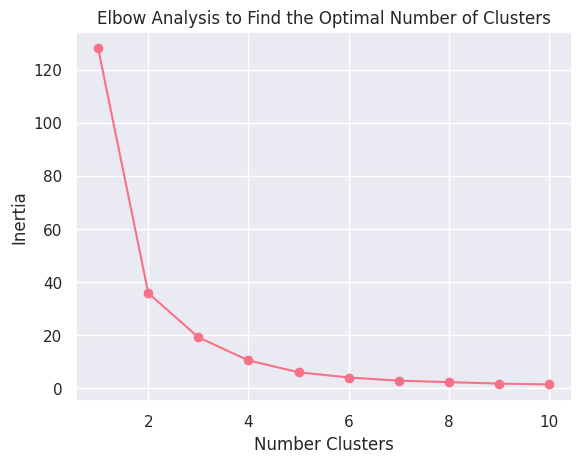

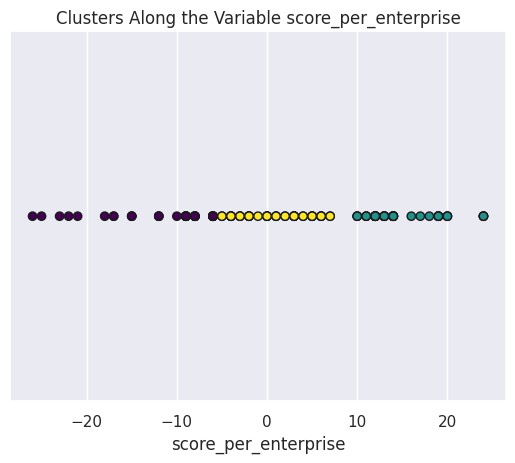

In [48]:
score_reshape = rtrs_sentiment_analysis['score_per_enterprise'].values.reshape(-1, 1)

scaler = StandardScaler()
data = scaler.fit_transform(score_reshape)

num_clusters = range(1, 11)
inertia = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

kmeans_otimo = KMeans(n_clusters=3, n_init=10, random_state=42)
rtrs_sentiment_analysis['cluster'] = kmeans_otimo.fit_predict(data)

plt.plot(num_clusters, inertia, marker='o')
plt.title('Elbow Analysis to Find the Optimal Number of Clusters')
plt.xlabel('Number Clusters')
plt.ylabel('Inertia')
plt.savefig('Elbow_Analysis_to_Find_the_Optimal_Number_of_Clusters.png', dpi=300, transparent=True)

plt.show()

plt.scatter(rtrs_sentiment_analysis['score_per_enterprise'], [0] * len(rtrs_sentiment_analysis), 
            c=rtrs_sentiment_analysis['cluster'], cmap='viridis', 
            marker='o', edgecolor='k')
plt.title('Clusters Along the Variable score_per_enterprise')
plt.xlabel('score_per_enterprise')
plt.yticks([]) 

plt.savefig('Clusters_along_the_Variable_score_per_enterprise.png', dpi=300, transparent=True)
plt.show()

# Correlation

In [49]:
rtrs_sentiment_analysis.iloc[:, :29]

1_1_criteria  1_2_criteria  1_3_criteria  2_1_criteria  2_2_criteria  \
0               1             1             1            -2             1   
1              -2             0             1            -2             1   
2               1             0             1            -2             0   
3               1             1             1            -2             1   
4              -2             1            -2            -2             0   
..            ...           ...           ...           ...           ...   
123             1             1             1            -2             1   
124             1             1             1            -2            -2   
125            -2             2             0            -2             1   
126             1             1             1            -2             0   
127             1             1             1            -2             1   

     2_3_criteria  2_4_criteria  2_5_criteria  3_1_criteria  3_2_criteria  \
0               1            -2            -2             0            -2   
1               0            -2            -2            -2             0   
2               1             0             0             0             1   
3               1             0            -2             1             1   
4               0            -2            -2            -2            -2   
..            ...           ...           ...           ...           ...   
123             1             1             1             1             1   
124             1             0             0             0             1   
125            -2            -2            -2             0             0   
126             1            -2            -2             1             1   
127             0            -2             0            -2             1   

     ...  5_3_criteria  5_4_criteria  5_5_criteria  5_6_criteria  \
0    ...             1            -2            -2             1   
1    ...             1             0            -2            -2   
2    ...             1             1            -2            -2   
3    ...             1             1            -2             1   
4    ...             1            -2            -2             1   
..   ...           ...           ...           ...           ...   
123  ...             1             1            -2             0   
124  ...             1             1             1            -2   
125  ...             1             0            -2             0   
126  ...             1             0            -2             0   
127  ...             1             1            -2            -2   

     5_7_criteria  5_8_criteria  5_9_criteria  5_10_criteria  5_11_criteria  \
0               1            -2             0              1             -2   
1               1            -2            -2             -1             -2   
2               1             0             0              0             -2   
3               1             1             0              1              1   
4               1            -2            -2              1             -2   
..            ...           ...           ...            ...            ...   
123             2             1             1              0              2   
124             1             1             0              0             -2   
125             2            -2             0             -1             -2   
126            -2            -2             1             -1             -2   
127             1             1             1              0             -2   

     score_per_enterprise  
0                      -5  
1                     -18  
2                       2  
3                       7  
4                     -17  
..                    ...  
123                    18  
124                     5  
125                   -17  
126                    -8  
127                     0  

[128 rows x 29 columns]

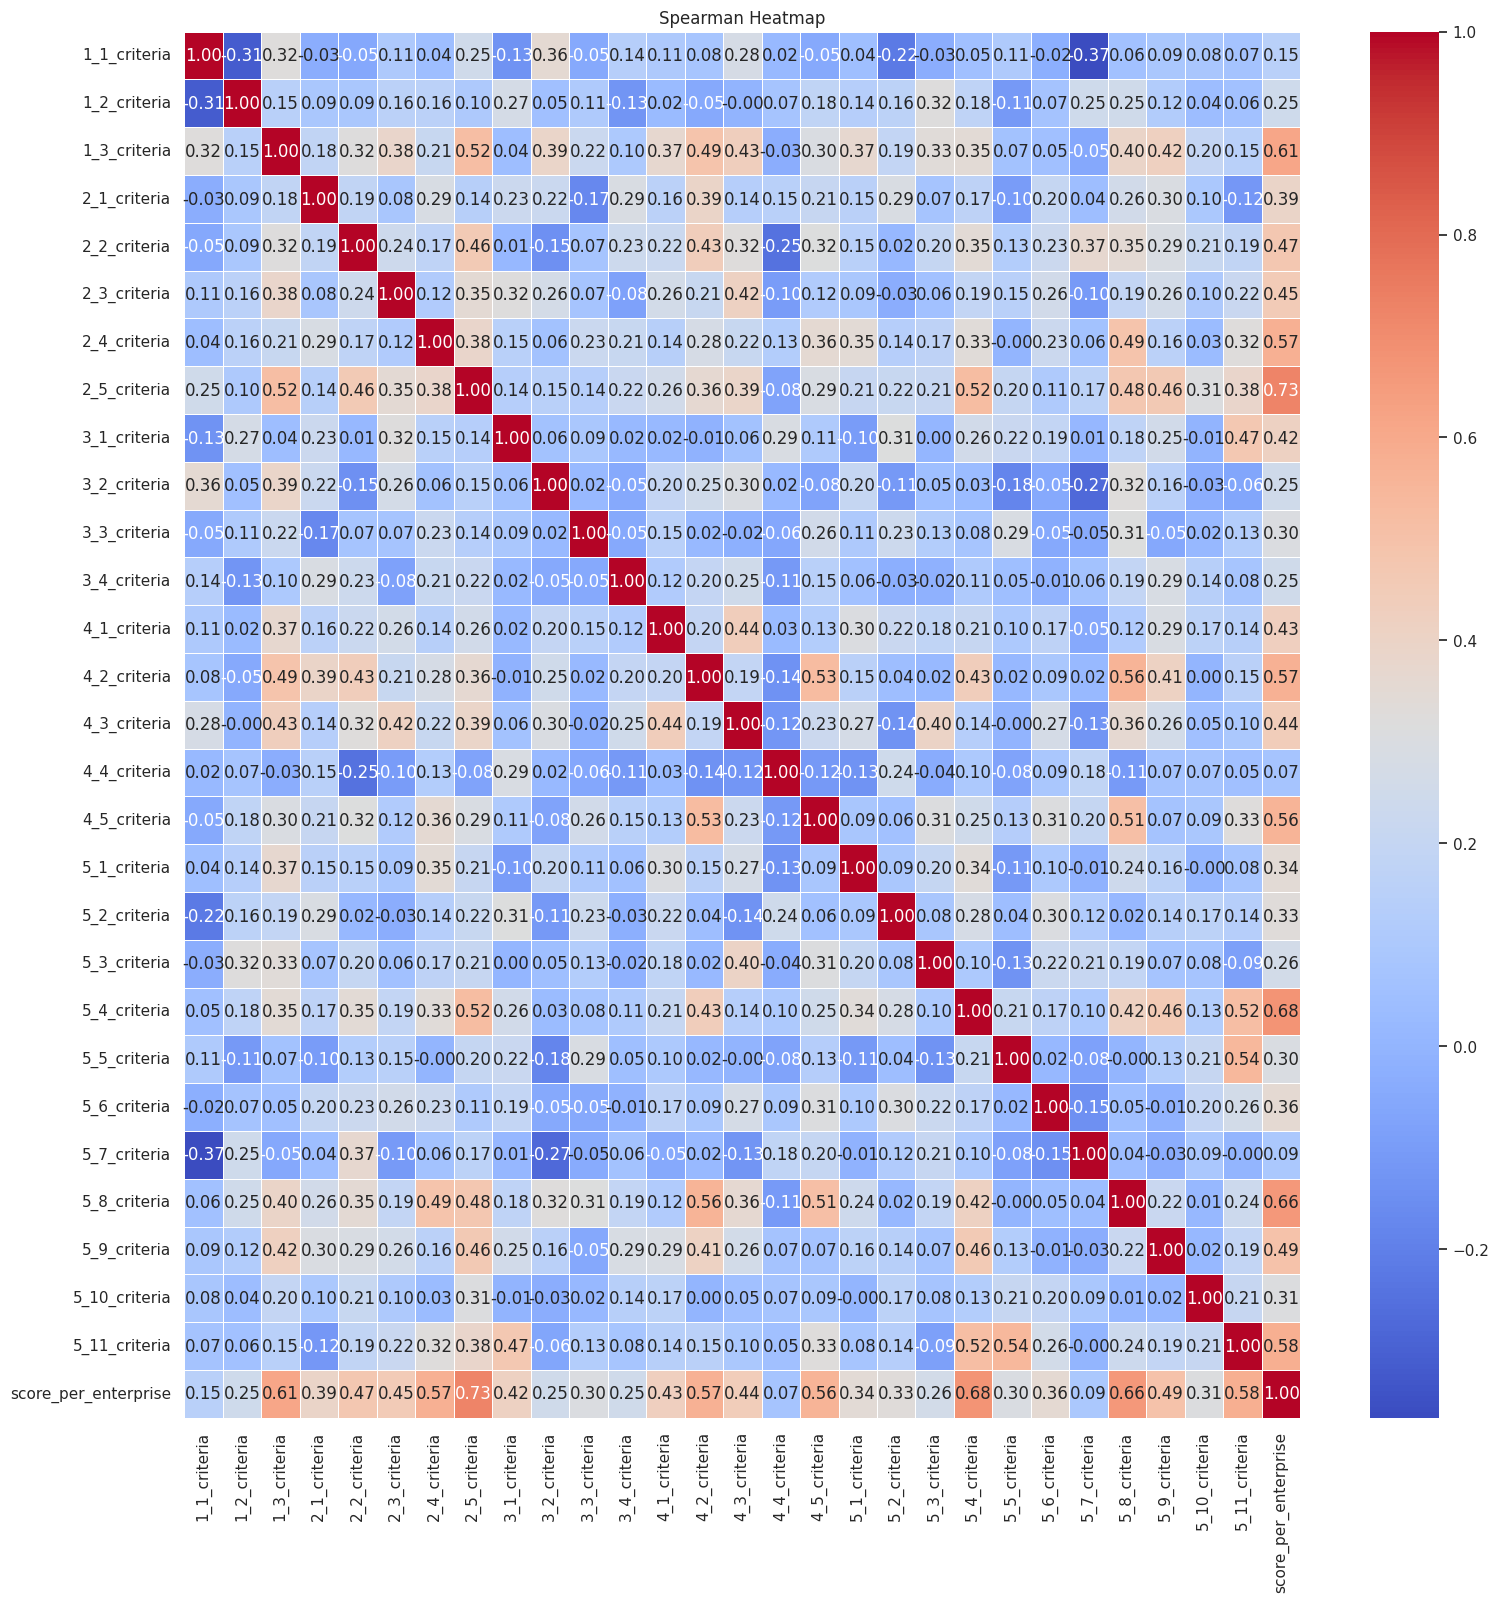

In [50]:
correlation_data =rtrs_sentiment_analysis.iloc[:, :29].corr(method='spearman')

plt.figure(figsize=(18, 18))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Spearman Heatmap')
plt.savefig('spearman_heatmap.png', dpi=300, transparent=True)
plt.show()

# Principal Components Analisys

In [51]:
X = rtrs_sentiment_analysis.iloc[:, :28]  
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [53]:
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
num_components_optimal = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1

In [54]:
explained_variance_df = pd.DataFrame({
    'Components Number': np.arange(1, len(explained_variance_ratio_cumsum) + 1),
    'Cumulative Explained Variation': explained_variance_ratio_cumsum
})
explained_variance_df.to_csv('Cumulative_Explained_Variation.csv')

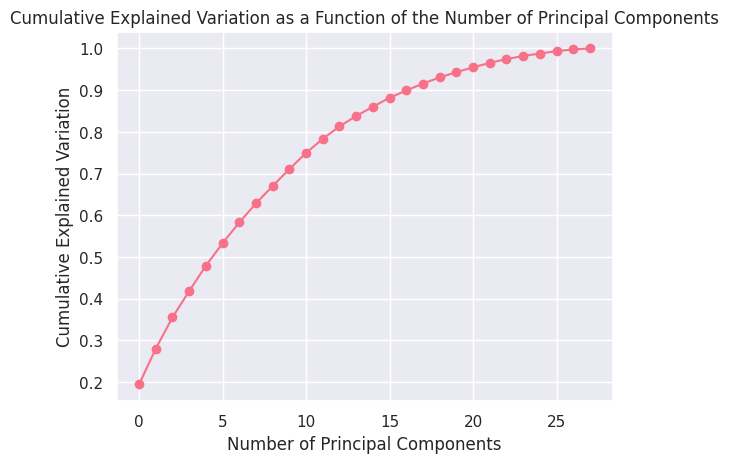

Number Components Optimal: 21


In [55]:
plt.plot(explained_variance_ratio_cumsum, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variation')
plt.title('Cumulative Explained Variation as a Function of the Number of Principal Components')
plt.savefig('Cumulative_Explained_Variation_As_Function_of_Number_of_Principal_Components.png', dpi=300, transparent=True)

plt.show()

print(f'Number Components Optimal: {num_components_optimal}')

In [56]:
loadings = pca.components_

loadings_df = pd.DataFrame(loadings.T, columns=[f'Principal Component {i+1}' for i in range(len(loadings))], index=X.columns)

print("Loadings:")
loadings_df.to_csv('Loadings_Criterias.csv')
loadings_df.head(10)

Loadings:


Principal Component 1  Principal Component 2  \
1_1_criteria              -0.154940              -0.246469   
1_2_criteria              -0.118859               0.121022   
1_3_criteria              -0.305835              -0.175309   
2_1_criteria              -0.174787              -0.063168   
2_2_criteria              -0.229692              -0.111391   
2_3_criteria              -0.156866              -0.068653   
2_4_criteria              -0.239410               0.078239   
2_5_criteria              -0.327169              -0.003191   
3_1_criteria              -0.114944               0.358862   
3_2_criteria              -0.124140              -0.327260   

              Principal Component 3  Principal Component 4  \
1_1_criteria               0.363978              -0.065654   
1_2_criteria              -0.201345               0.079413   
1_3_criteria               0.092002               0.033369   
2_1_criteria              -0.099811               0.235899   
2_2_criteria              -0.079318              -0.279167   
2_3_criteria               0.120445              -0.329809   
2_4_criteria              -0.083014               0.275017   
2_5_criteria               0.055875              -0.116908   
3_1_criteria               0.153247               0.007929   
3_2_criteria               0.189516               0.066637   

              Principal Component 5  Principal Component 6  \
1_1_criteria               0.096187               0.010826   
1_2_criteria              -0.198032              -0.331765   
1_3_criteria               0.020778              -0.223268   
2_1_criteria              -0.265411               0.297594   
2_2_criteria               0.050930               0.261635   
2_3_criteria              -0.236222              -0.071810   
2_4_criteria               0.048227              -0.017888   
2_5_criteria               0.085605               0.052282   
3_1_criteria              -0.238474              -0.051223   
3_2_criteria              -0.140951              -0.339699   

              Principal Component 7  Principal Component 8  \
1_1_criteria               0.295123               0.046092   
1_2_criteria              -0.198003              -0.284599   
1_3_criteria              -0.030631              -0.104208   
2_1_criteria               0.049766              -0.187193   
2_2_criteria              -0.108502              -0.157544   
2_3_criteria              -0.356636               0.189848   
2_4_criteria               0.248341               0.147483   
2_5_criteria              -0.035239              -0.001127   
3_1_criteria              -0.167832              -0.154228   
3_2_criteria              -0.116406               0.005583   

              Principal Component 9  Principal Component 10  ...  \
1_1_criteria               0.281659               -0.073004  ...   
1_2_criteria              -0.269647                0.078651  ...   
1_3_criteria               0.010359               -0.151392  ...   
2_1_criteria               0.137211                0.357062  ...   
2_2_criteria              -0.144971               -0.039125  ...   
2_3_criteria              -0.077183                0.200785  ...   
2_4_criteria              -0.091816                0.108394  ...   
2_5_criteria               0.168247                0.022828  ...   
3_1_criteria              -0.037655               -0.045386  ...   
3_2_criteria              -0.089744                0.331279  ...   

              Principal Component 19  Principal Component 20  \
1_1_criteria               -0.024040                0.071937   
1_2_criteria                0.153447                0.032693   
1_3_criteria                0.318683               -0.074505   
2_1_criteria               -0.245234               -0.159237   
2_2_criteria               -0.083658               -0.083612   
2_3_criteria                0.088172               -0.270175   
2_4_criteria                0.242810               -0.200023   
2_5_criteria         

In [57]:
rtrs_sentiment_analysis.to_csv('rtrs_sentiment_analisys.csv')

# For Principles and not Criterias

If you notice, each criterion forms a group of principles. In all, there are 5 guiding principles for the soy certification standard. 

In [58]:
prefixs = set(coluna.split('_')[0] for coluna in rtrs_sentiment_analysis.iloc[:, :28].columns)

In [59]:
prefixs

{'1', '2', '3', '4', '5'}

In [60]:
for prefix in prefixs:
    group_cols = [col for col in rtrs_sentiment_analysis.iloc[:, :28].columns if col.startswith(f"{prefix}_")]
    rtrs_sentiment_analysis[f"{prefix}_principle"] = rtrs_sentiment_analysis[group_cols].sum(axis=1)

In [61]:
rtrs_sentiment_analysis.iloc[:, 32:].to_csv('principle_sentiment_analisys.csv')

In [62]:
cols_corr = ['4_principle', '3_principle','2_principle', '5_principle', '1_principle', 'score_per_enterprise']

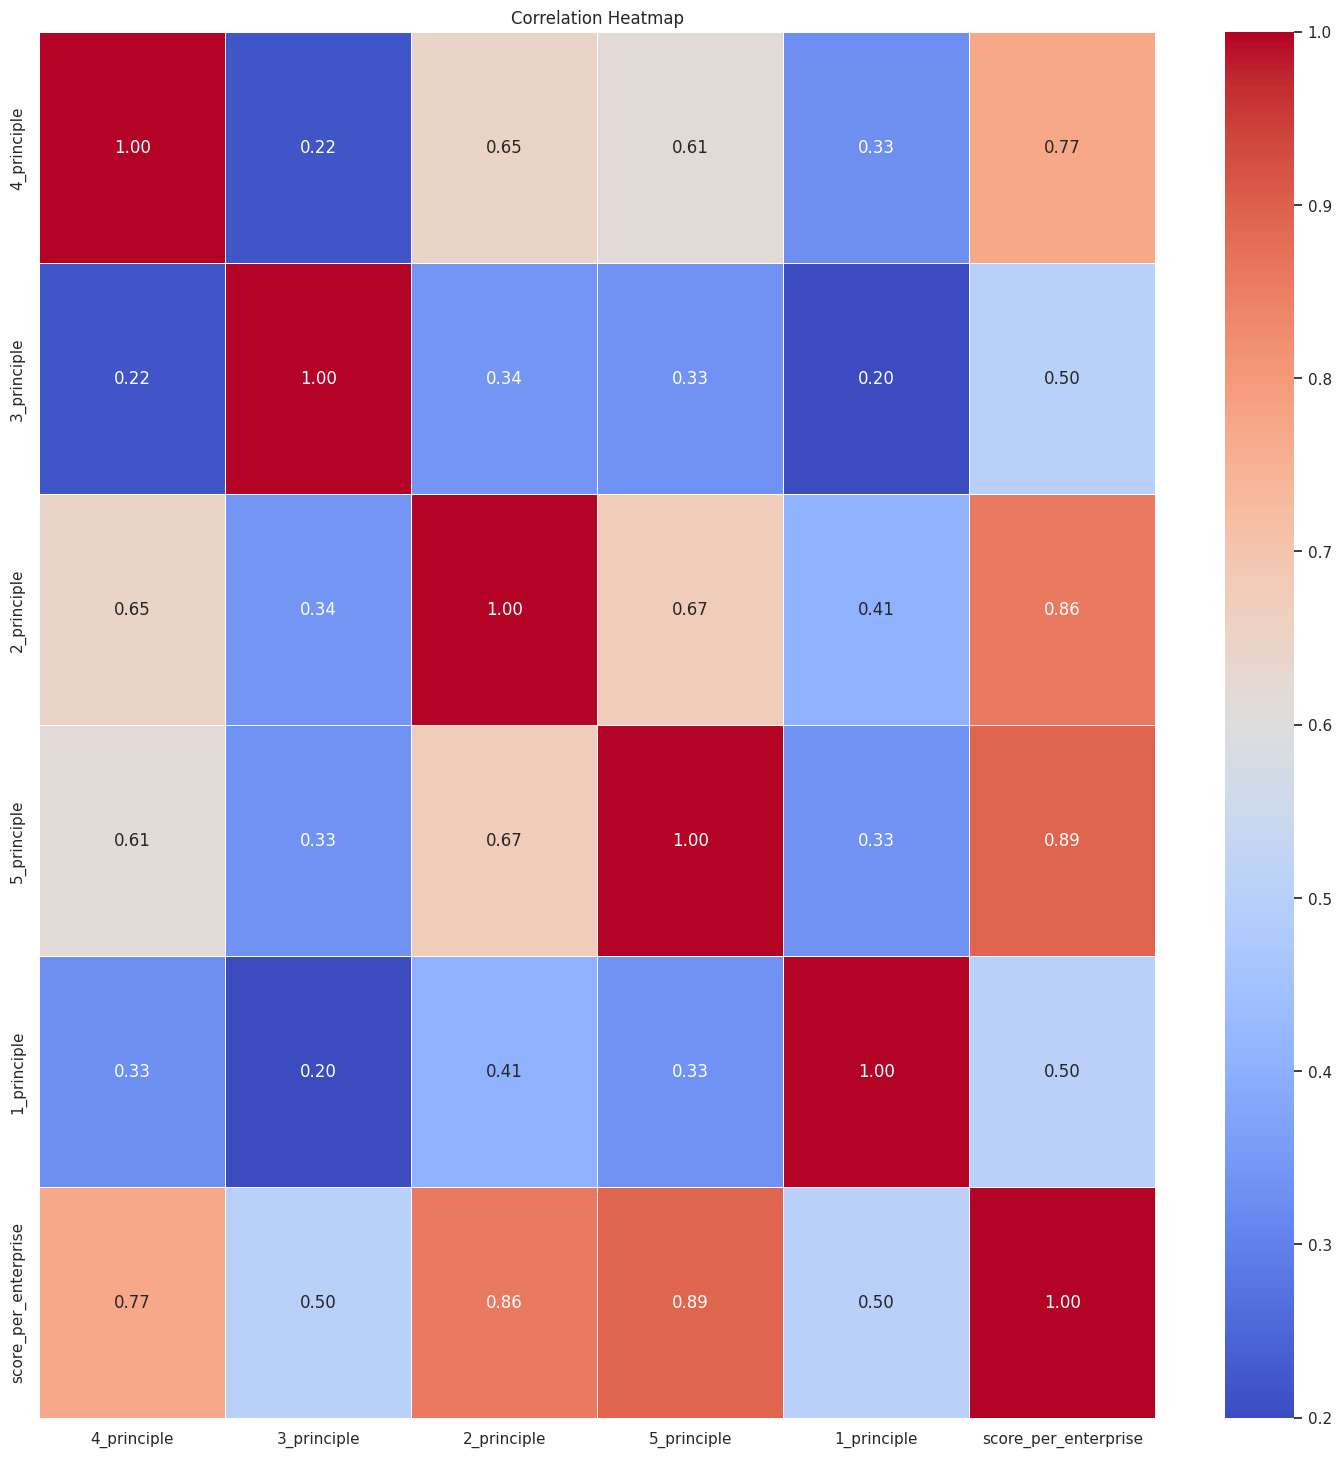

In [63]:
correlation_data =rtrs_sentiment_analysis[cols_corr].corr(method='spearman')

plt.figure(figsize=(18, 18))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.savefig('principle_corr_heatmap_spearman.png', dpi=300, transparent=True)
plt.show()

In [64]:
X = rtrs_sentiment_analysis.iloc[:, 32:]
pca = PCA()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [66]:
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
num_components_optimal = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1

In [67]:
explained_variance_df = pd.DataFrame({
    'Components Number': np.arange(1, len(explained_variance_ratio_cumsum) + 1),
    'Cumulative Explained Variation': explained_variance_ratio_cumsum
})
explained_variance_df.to_csv('Cumulative_Explained_Variation_Principle.csv')

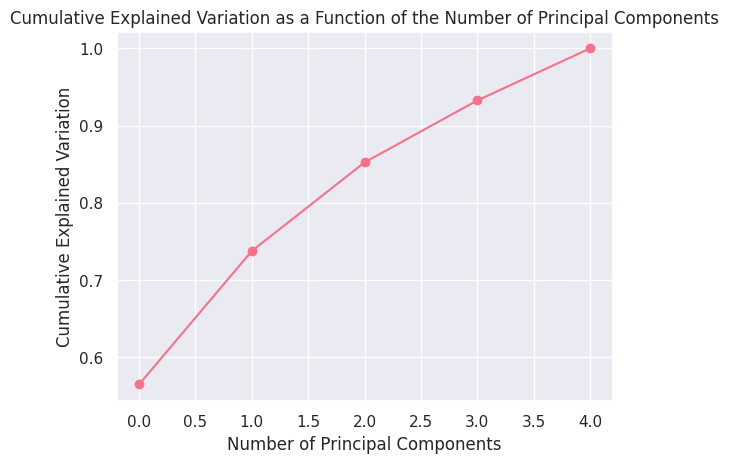

Number Components Optimal: 5


In [68]:
plt.plot(explained_variance_ratio_cumsum, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variation')
plt.title('Cumulative Explained Variation as a Function of the Number of Principal Components')
plt.savefig('Cumulative_Explained_Variation_As_Function_of_Number_of_Principal_Components.png', dpi=300, transparent=True)

plt.show()

print(f'Number Components Optimal: {num_components_optimal}')

In [69]:
loadings = pca.components_

loadings_df = pd.DataFrame(loadings.T, columns=[f'Principal Component {i+1}' for i in range(len(loadings))], index=X.columns)

print("Loadings:")
loadings_df.to_csv('Loadings_Criterias.csv')
loadings_df.head(10)

Loadings:


Principal Component 1  Principal Component 2  \
1_principle              -0.427896               0.344860   
5_principle              -0.476155              -0.215101   
4_principle              -0.463455              -0.425399   
3_principle              -0.346864               0.774851   
2_principle              -0.505051              -0.231180   

             Principal Component 3  Principal Component 4  \
1_principle              -0.766021               0.304636   
5_principle               0.472797               0.584520   
4_principle              -0.136284              -0.673692   
3_principle               0.411079              -0.332106   
2_principle               0.045987               0.037118   

             Principal Component 5  
1_principle               0.135590  
5_principle               0.402253  
4_principle               0.363058  
3_principle               0.003172  
2_principle              -0.829450

# Conclusion

The identification of sentiment clusters in audit reports using PCA and bert-multilingual-sentiment-analysis provides one solution. For instance, it can help in quickly identifying reports that express discourse sentiment standards, which might indicate areas of concern in soybean production or supply chain practices. Conversely, clusters with another standard discourse sentiments can highlight best practices or areas of excellence. This clustering not only aids in swift decision-making but also in understanding the nuanced sentiment landscape across different enterprises and possible no-compliance with principles.